# Synthetic Controls Comparison Data Analysis 

In [173]:
%%capture
# Capture suppresses output to screen
import stata_setup
stata_setup.config("/Applications/Stata 17", "be")

In [174]:
%%stata
/* Define input and output paths */
global data "Data"
global output "Output"
global graphs "$output/Graphs"
global tables "$output/Tables"

global synth "$data/Synth"
global placebo "$synth/Placebo"

global processed "$data/Processed"

global finalSynthData "$processed/finalSynth.dta"


. /* Define input and output paths */
. global data "Data"

. global output "Output"

. global graphs "$output/Graphs"

. global tables "$output/Tables"

. 
. global synth "$data/Synth"

. global placebo "$synth/Placebo"

. 
. global processed "$data/Processed"

. 
. global finalSynthData "$processed/finalSynth.dta"

. 


In [175]:
%%capture
%%stata
log using "$output/analysis-Syth.log", replace

## Read in Master Data File

In [199]:
%%stata
use "$finalSynthData", clear
describe


. use "$finalSynthData", clear

. describe

Contains data from Data/Processed/finalSynth.dta
 Observations:           646                  
    Variables:            24                  5 Feb 2022 19:04
-------------------------------------------------------------------------------
Variable      Storage   Display    Value
    name         type    format    label      Variable label
-------------------------------------------------------------------------------
year            float   %10.0g                Year
employment      long    %10.0g                Annual Reported Employment (NAICS
                                                3364)
state           str2    %9s                   
annualPay       long    %10.0g                Average Annual Pay (USD) (NAICS
                                                3364)
lnEmployment    float   %9.0g                 
lnAnnualPay     float   %9.0g                 
unemploy        double  %10.0g                Annual state level unemploymen

In [200]:
%%stata
list year annualPay if fips==53


     +-----------------+
     | year   annual~y |
     |-----------------|
590. | 2001      65162 |
591. | 2002      71465 |
592. | 2003      73460 |
593. | 2004      77747 |
594. | 2005      84146 |
     |-----------------|
595. | 2006      90155 |
596. | 2007      86735 |
597. | 2008      87114 |
598. | 2009      87887 |
599. | 2010      91526 |
     |-----------------|
600. | 2011      97215 |
601. | 2012      96688 |
602. | 2013     100105 |
603. | 2014     110016 |
604. | 2015     107138 |
     |-----------------|
605. | 2016     108274 |
606. | 2017     113798 |
607. | 2018     119650 |
608. | 2019     118995 |
     +-----------------+


## Evaluate missing values in the data

In [177]:
%%stata
misstable summarize employment annualPay pop unemploy

                                                             Obs<.
                                                +------------------------------
               |                                | Unique
      Variable |     Obs=.     Obs>.     Obs<.  | values        Min         Max
  -------------+--------------------------------+------------------------------
    employment |         4                 642  |   >500        452       96012
     annualPay |         4                 642  |   >500      34951      138768
  -----------------------------------------------------------------------------


In [178]:
%%stata
list year state employment annualPay ///
    if employment==. | annualPay==.


. list year state employment annualPay ///
>     if employment==. | annualPay==.

     +------------------------------------+
     | year   state   employ~t   annual~y |
     |------------------------------------|
495. | 2001      SC          .          . |
496. | 2002      SC          .          . |
497. | 2003      SC          .          . |
498. | 2004      SC          .          . |
     +------------------------------------+

. 


In [179]:
%%stata
list year employment annualPay if state=="SC"


     +----------------------------+
     | year   employ~t   annual~y |
     |----------------------------|
495. | 2001          .          . |
496. | 2002          .          . |
497. | 2003          .          . |
498. | 2004          .          . |
499. | 2005        452      61448 |
     |----------------------------|
500. | 2006        515      63420 |
501. | 2007        866      67915 |
502. | 2008       1365      66607 |
503. | 2009       1917      68722 |
504. | 2010       2993      72933 |
     |----------------------------|
505. | 2011       4534      76650 |
506. | 2012       5867      74753 |
507. | 2013       6531      80758 |
508. | 2014       7002      91915 |
509. | 2015       7340      86881 |
     |----------------------------|
510. | 2016       7920      86006 |
511. | 2017       7631      86249 |
512. | 2018       7178      93363 |
513. | 2019       7381     100039 |
     +----------------------------+


## Drop data prior to 2001-2004 
South Carolina had not significant NAICS 3364 industry prior to 2005 but has
as significant industry in period afterwards.

Treatment period of interest is 2014. 

In [180]:
%%stata
drop if year < 2005

(136 observations deleted)



. // Plot SC Employment and Annual Pay over time
. twoway (connected employment year, yaxis(1)) /// 
>     (line annualPay year, yaxis(2)) ///
>     if state=="SC", ///
>     title("South Carolina Aerospace Employment and Pay") ///
>     subtitle("NAICS 3364 - Aerospace Product and Parts Manufacturing") ///
>     ytitle(Annual Employment) ///
>     ytitle("Annual Pay (USD)", axis(2)) ///
>     legend( label(1 "Employment") label(2 "Annual Pay")) ///
>     xmtick(##2) graphregion(fcolor(white)) ///
>     ylabel(,axis(1) format(%9.0gc)) ///
>     ylabel(,axis(2) format(%9.0gc)) ///
>     note("Source: BLS QCEW")

.         
. graph export $graphs/SC_EmploymentPay.png, replace
file Output/Graphs/SC_EmploymentPay.png written in PNG format

. 


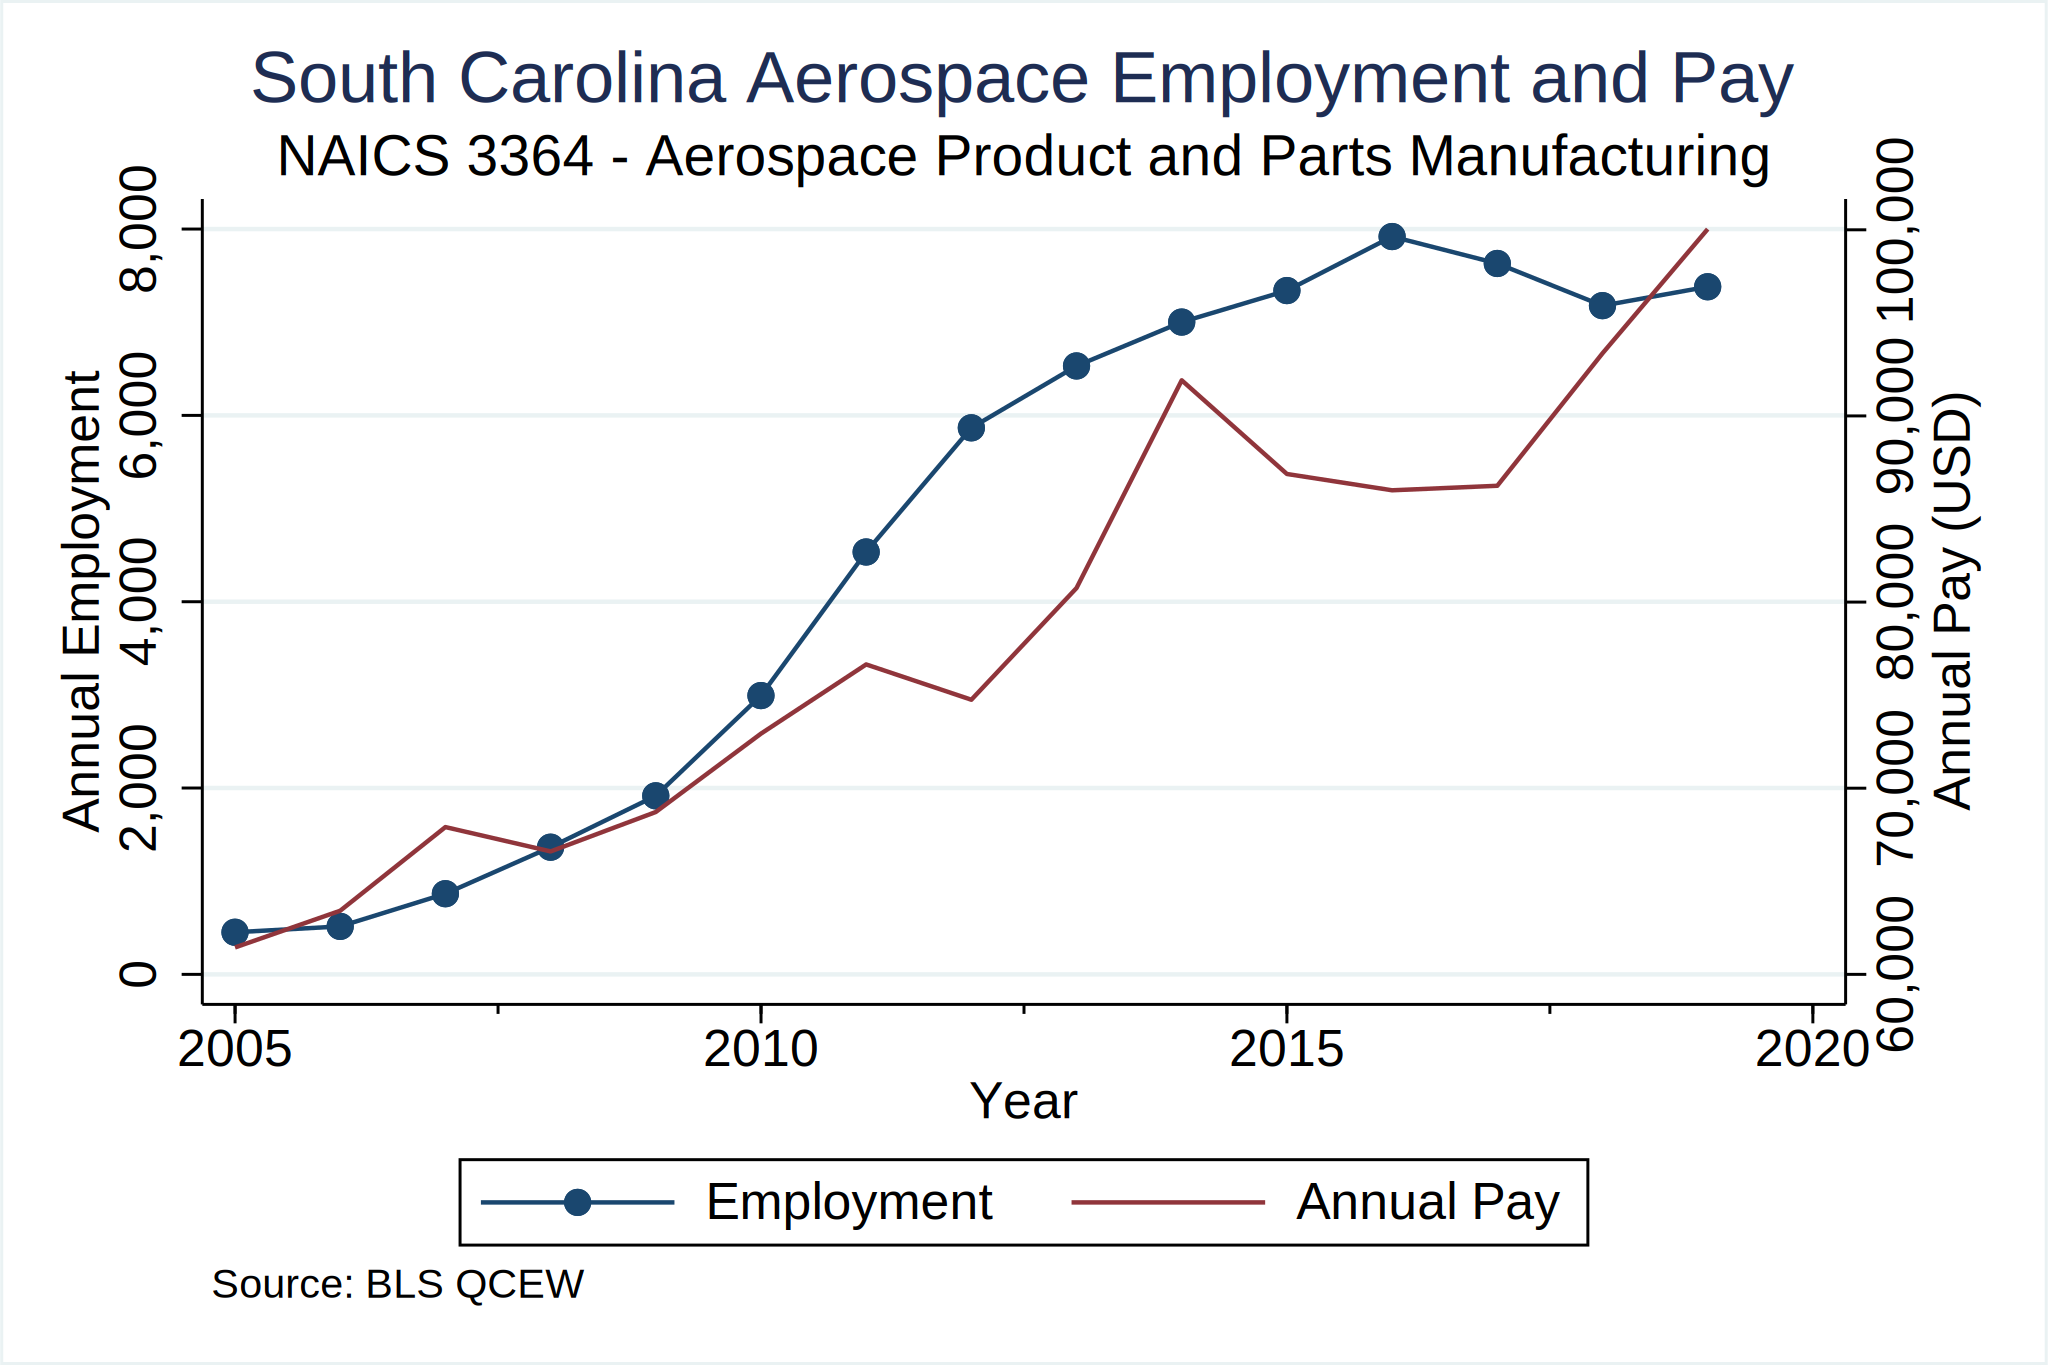

In [181]:
%%stata
// Plot SC Employment and Annual Pay over time
twoway (connected employment year, yaxis(1)) /// 
    (line annualPay year, yaxis(2)) ///
    if state=="SC", ///
    title("South Carolina Aerospace Employment and Pay") ///
    subtitle("NAICS 3364 - Aerospace Product and Parts Manufacturing") ///
    ytitle(Annual Employment) ///
    ytitle("Annual Pay (USD)", axis(2)) ///
    legend( label(1 "Employment") label(2 "Annual Pay")) ///
    xmtick(##2) graphregion(fcolor(white)) ///
    ylabel(,axis(1) format(%9.0gc)) ///
    ylabel(,axis(2) format(%9.0gc)) ///
    note("Source: BLS QCEW")
        
graph export $graphs/SC_EmploymentPay.png, replace

## Summarize Final Dataset

In [182]:
%%stata
summarize
codebook fips


. summarize

    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
        year |        510        2012    4.324736       2005       2019
  employment |        510    14101.35    19611.59        452      96012
       state |          0
   annualPay |        510    80424.82    16832.16      46521     138768
lnEmployment |        510    8.782971    1.254583   6.113682   11.47223
-------------+---------------------------------------------------------
 lnAnnualPay |        510    11.27407    .2040536   10.74766   11.84056
    unemploy |        510     5.98451    2.134453        2.5       13.1
  lnUnemploy |        510    1.727651    .3511328   .9162908   2.572612
         pop |        510     8359618     7471377    1298492   3.95e+07
       lnPop |        510    15.64819    .7429893   14.07671   17.49212
-------------+---------------------------------------------------------
        fips |        51

In [183]:
%%stata
table state, statistic(mean employment) statistic(mean annualPay) ///
    nformat(%9.0fc) nototals


. table state, statistic(mean employment) statistic(mean annualPay) ///
>     nformat(%9.0fc) nototals

----------------------------------------------------------------------------------------
      |  Annual Reported Employment (NAICS 3364)   Average Annual Pay (USD) (NAICS 3364)
------+---------------------------------------------------------------------------------
state |                                                                                 
  AL  |                                   12,759                                  77,317
  AR  |                                    3,460                                  56,593
  AZ  |                                   27,048                                  92,645
  CA  |                                   72,826                                  96,015
  CO  |                                    7,301                                 112,814
  CT  |                                   30,086                                  98,498
  FL 

## Generate Summary Statistics for WA

In [184]:
%%stata
estpost summarize employment annualPay unemploy pop if state=="WA", quietly
eststo waSum


/* For Display */
esttab waSum, ///
    noobs nonumbers ///
    cells( (mean(fmt(%15.2fc) label("Mean")) min(label("Min")) max(label("Max")) ///
            count(label("Num Obs"))) /// 
          (sd(par label("SD")) ) ) ///
    coeflabels(employment "Annual Employment" ///
              annualPay "Annual Pay" ///
              unemploy "Annual Unemployment Rate" ///
              pop "Est Population") ///
    mtitles("WA") ///
    addnotes("Standard Deviations in paranthesis" "NAICS 3364 for years 2005-2019")


. estpost summarize employment annualPay unemploy pop if state=="WA", quietly

. eststo waSum

. 
. 
. /* For Display */
. esttab waSum, ///
>     noobs nonumbers ///
>     cells( (mean(fmt(%15.2fc) label("Mean")) min(label("Min")) max(label("Max
> ")) ///
>             count(label("Num Obs"))) /// 
>           (sd(par label("SD")) ) ) ///
>     coeflabels(employment "Annual Employment" ///
>               annualPay "Annual Pay" ///
>               unemploy "Annual Unemployment Rate" ///
>               pop "Est Population") ///
>     mtitles("WA") ///
>     addnotes("Standard Deviations in paranthesis" "NAICS 3364 for years 2005-
> 2019")

----------------------------------------------------------------
                       WA                                       
                  Mean/SD          Min          Max      Num Obs
----------------------------------------------------------------
Annual Emp~t    85,144.60    65,616.00    96,012.00        15.00
               (8,368.60)

---

## Run synthetic control analysis

In [185]:
%%stata
list fips state if state=="WA"


     +--------------+
     | fips   state |
     |--------------|
466. |   53      WA |
467. |   53      WA |
468. |   53      WA |
469. |   53      WA |
470. |   53      WA |
     |--------------|
471. |   53      WA |
472. |   53      WA |
473. |   53      WA |
474. |   53      WA |
475. |   53      WA |
     |--------------|
476. |   53      WA |
477. |   53      WA |
478. |   53      WA |
479. |   53      WA |
480. |   53      WA |
     +--------------+


## Employment Growth


. /* WA State is the treatment state.  WA is fips==53 */
. synth lnEmployment ///
>     lnEmployment(2010) lnEmployment(2011) lnEmployment(2012) lnEmployment(201
> 3) ///
>     lnUnemploy(2010) lnUnemploy(2011) lnUnemploy(2012) lnUnemploy(2013) ///
>     lnPop(2010) lnPop(2011) lnPop(2012) lnPop(2013), ///
>     trunit(53) trperiod(2014) unitnames(state) ///
>     msperiod(2005(1)2013) resultsperiod(2005(1)2019) replace figure
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: WA
               Control Units: AL, A

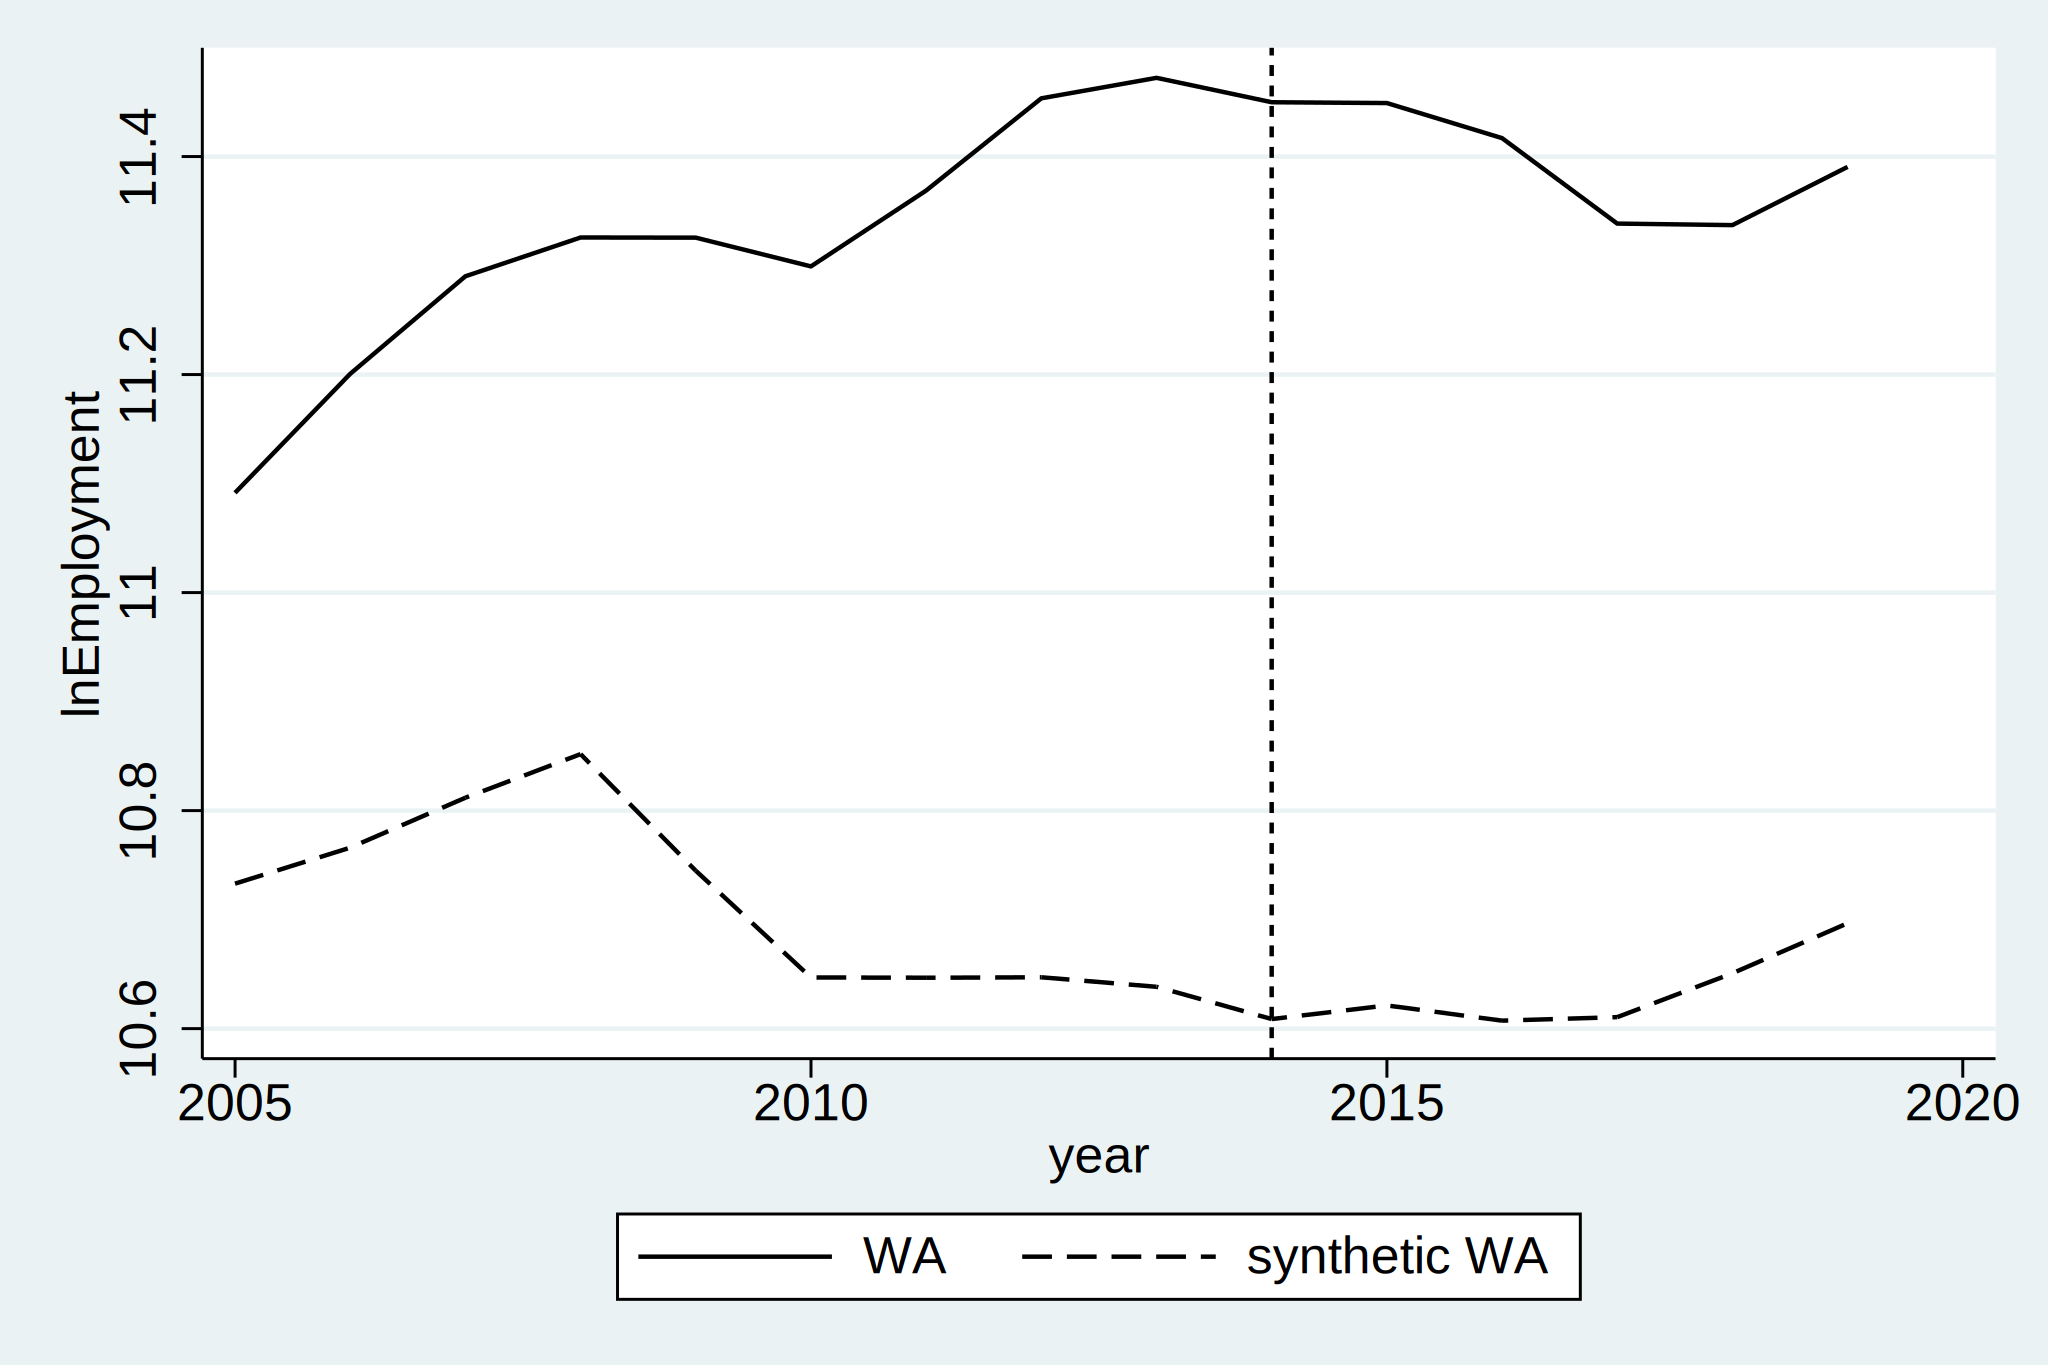

In [186]:
%%stata
/* WA State is the treatment state.  WA is fips==53 */
synth lnEmployment ///
    lnEmployment(2010) lnEmployment(2011) lnEmployment(2012) lnEmployment(2013) ///
    lnUnemploy(2010) lnUnemploy(2011) lnUnemploy(2012) lnUnemploy(2013) ///
    lnPop(2010) lnPop(2011) lnPop(2012) lnPop(2013), ///
    trunit(53) trperiod(2014) unitnames(state) ///
    msperiod(2005(1)2013) resultsperiod(2005(1)2019) replace figure


. /* Rename Graph */
. graph rename Graph synthWaEmploymentLn, replace

. 
. /*  Show the graph from the command above */
. graph display

. 


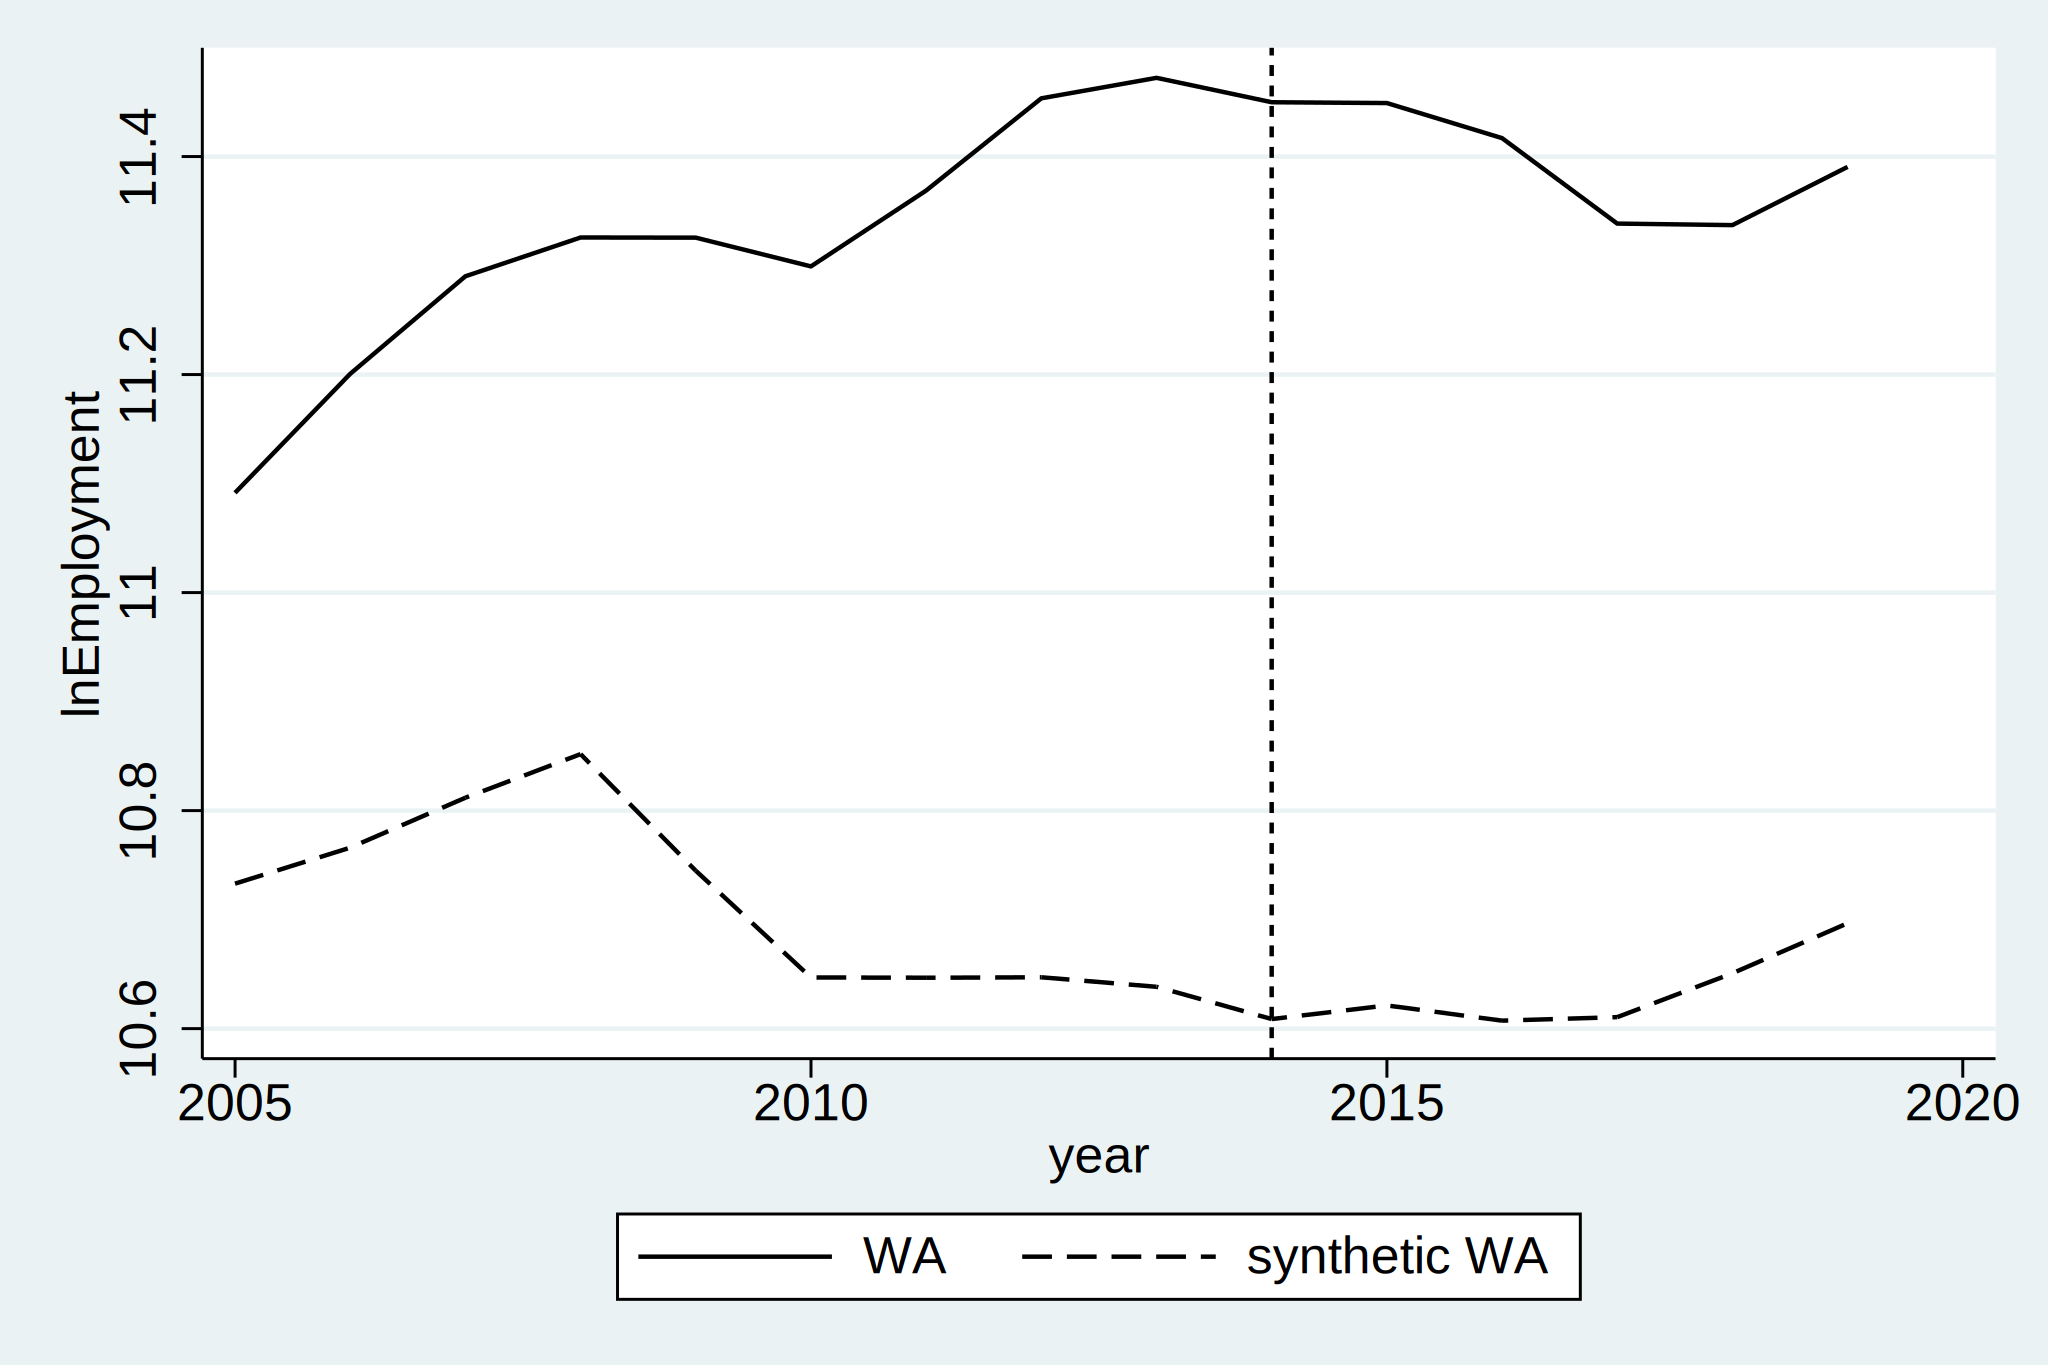

In [187]:
%%stata
/* Rename Graph */
graph rename Graph synthWaEmploymentLn, replace

/*  Show the graph from the command above */
graph display


. synth lnAnnualPay ///
>     lnAnnualPay(2010) lnAnnualPay(2011) lnAnnualPay(2012) lnAnnualPay(2013) /
> //
>     lnPop(2010) lnPop(2011) lnPop(2012) lnPop(2013), ///
>     trunit(53) trperiod(2014) unitnames(state) ///
>     msperiod(2005(1)2013) resultsperiod(2005(1)2019) ///
>     replace ///
>     figure
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: WA
               Control Units: AL, AZ, AR, CA, CO, CT, FL, GA, IL, IN, KS, KY,
                              MD, MA, MI, MS, MO, NH, NJ, NM, NY, NC, OH, OK,

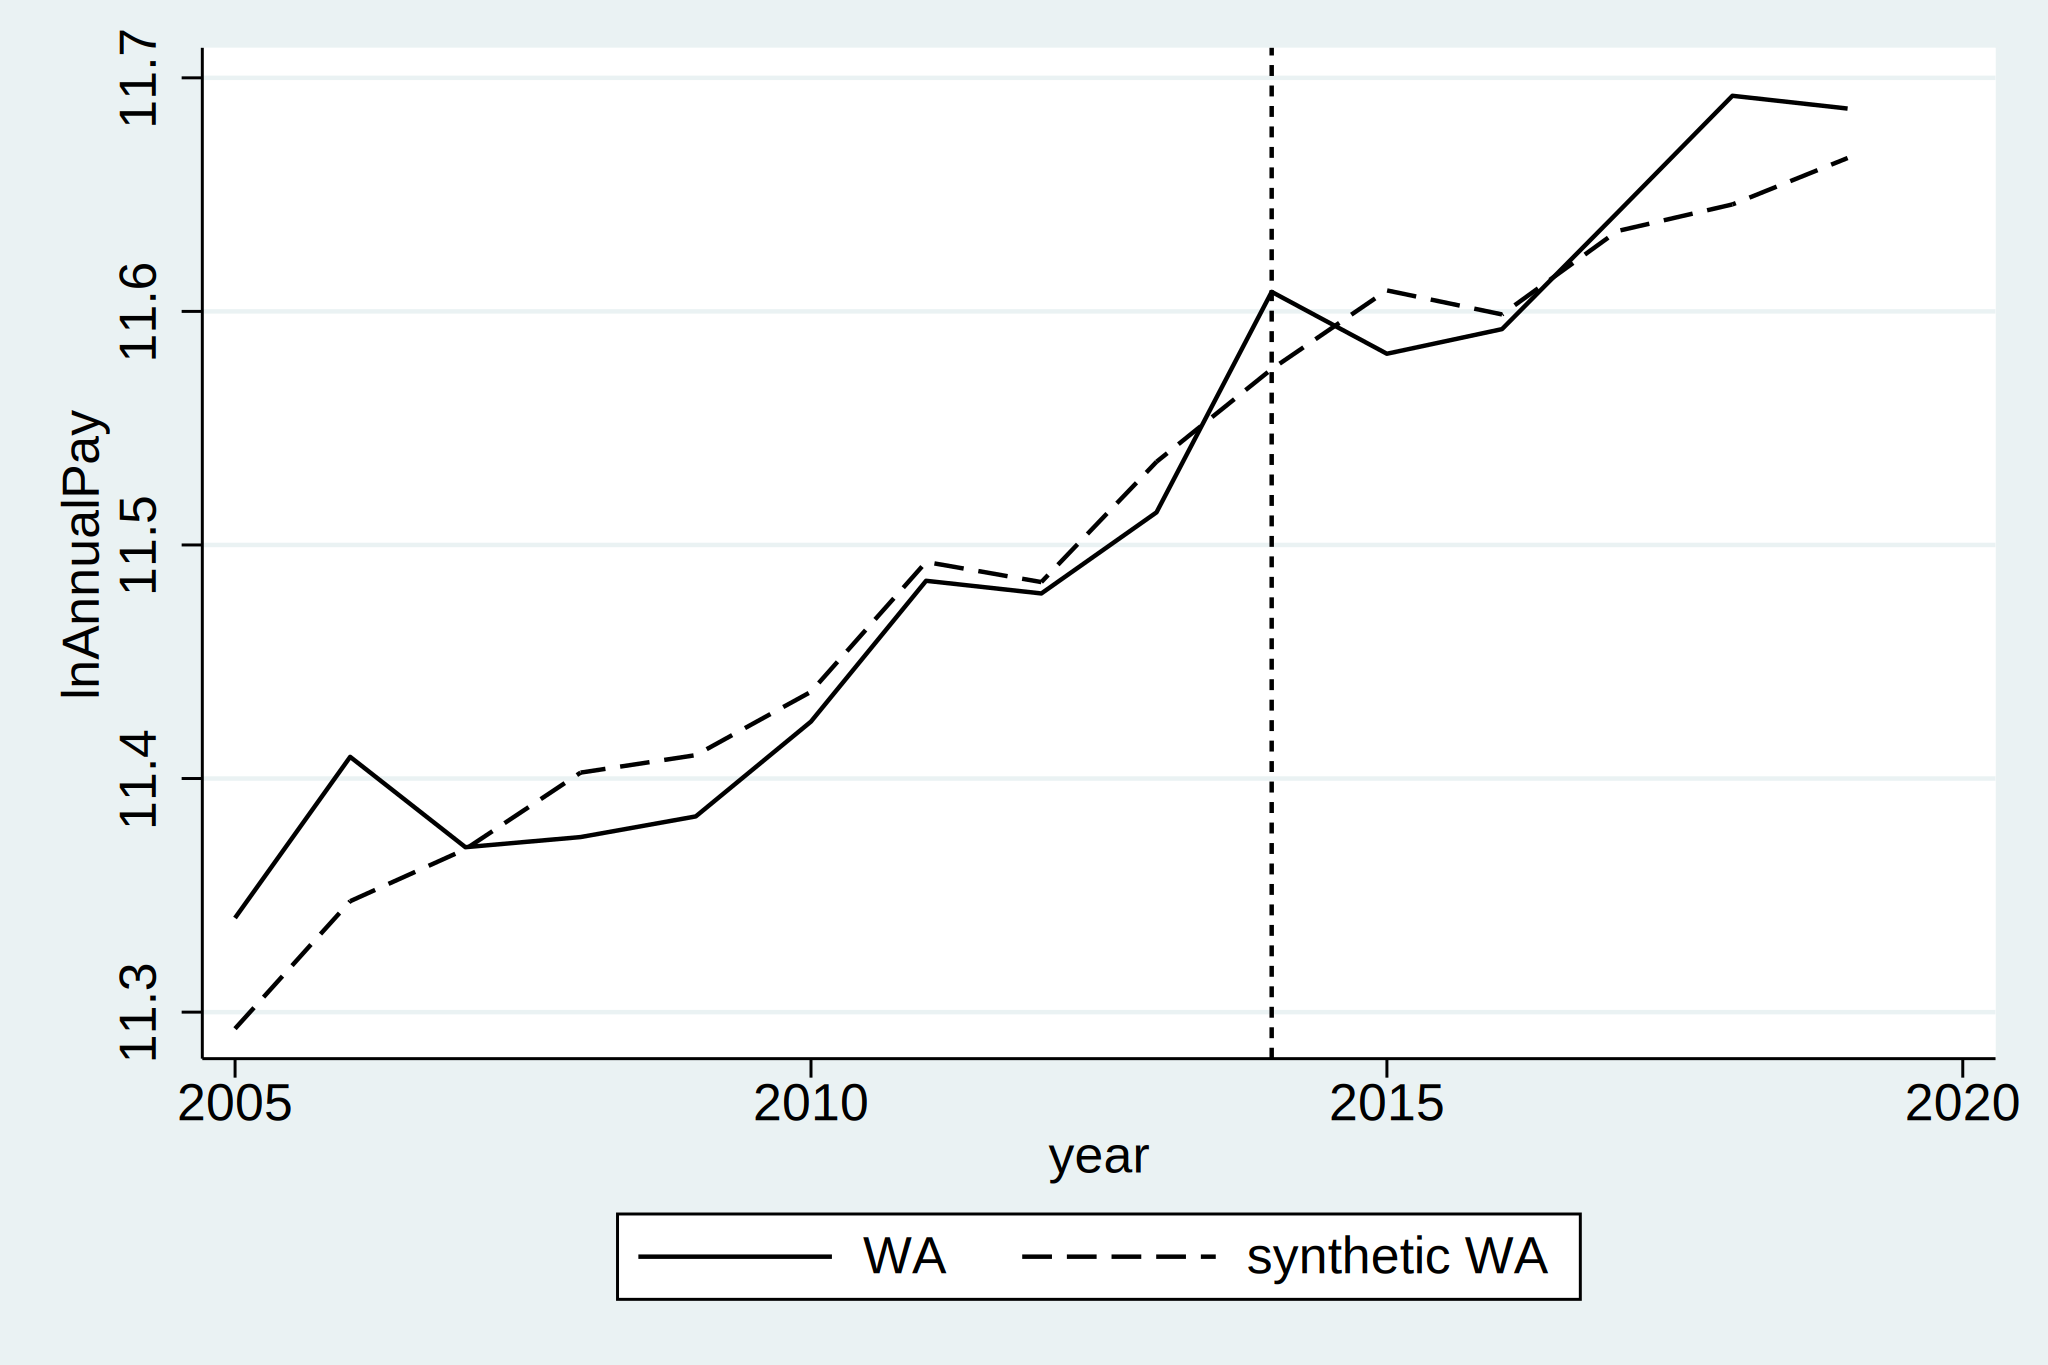

In [188]:
%%stata
synth lnAnnualPay ///
    lnAnnualPay(2010) lnAnnualPay(2011) lnAnnualPay(2012) lnAnnualPay(2013) ///
    lnPop(2010) lnPop(2011) lnPop(2012) lnPop(2013), ///
    trunit(53) trperiod(2014) unitnames(state) ///
    msperiod(2005(1)2013) resultsperiod(2005(1)2019) ///
    replace ///
    figure


. /* Rename Graph */
. graph rename Graph synthWaAnnualPayLn, replace

. 
. /*  Show the graph from the command above */
. graph display

. 


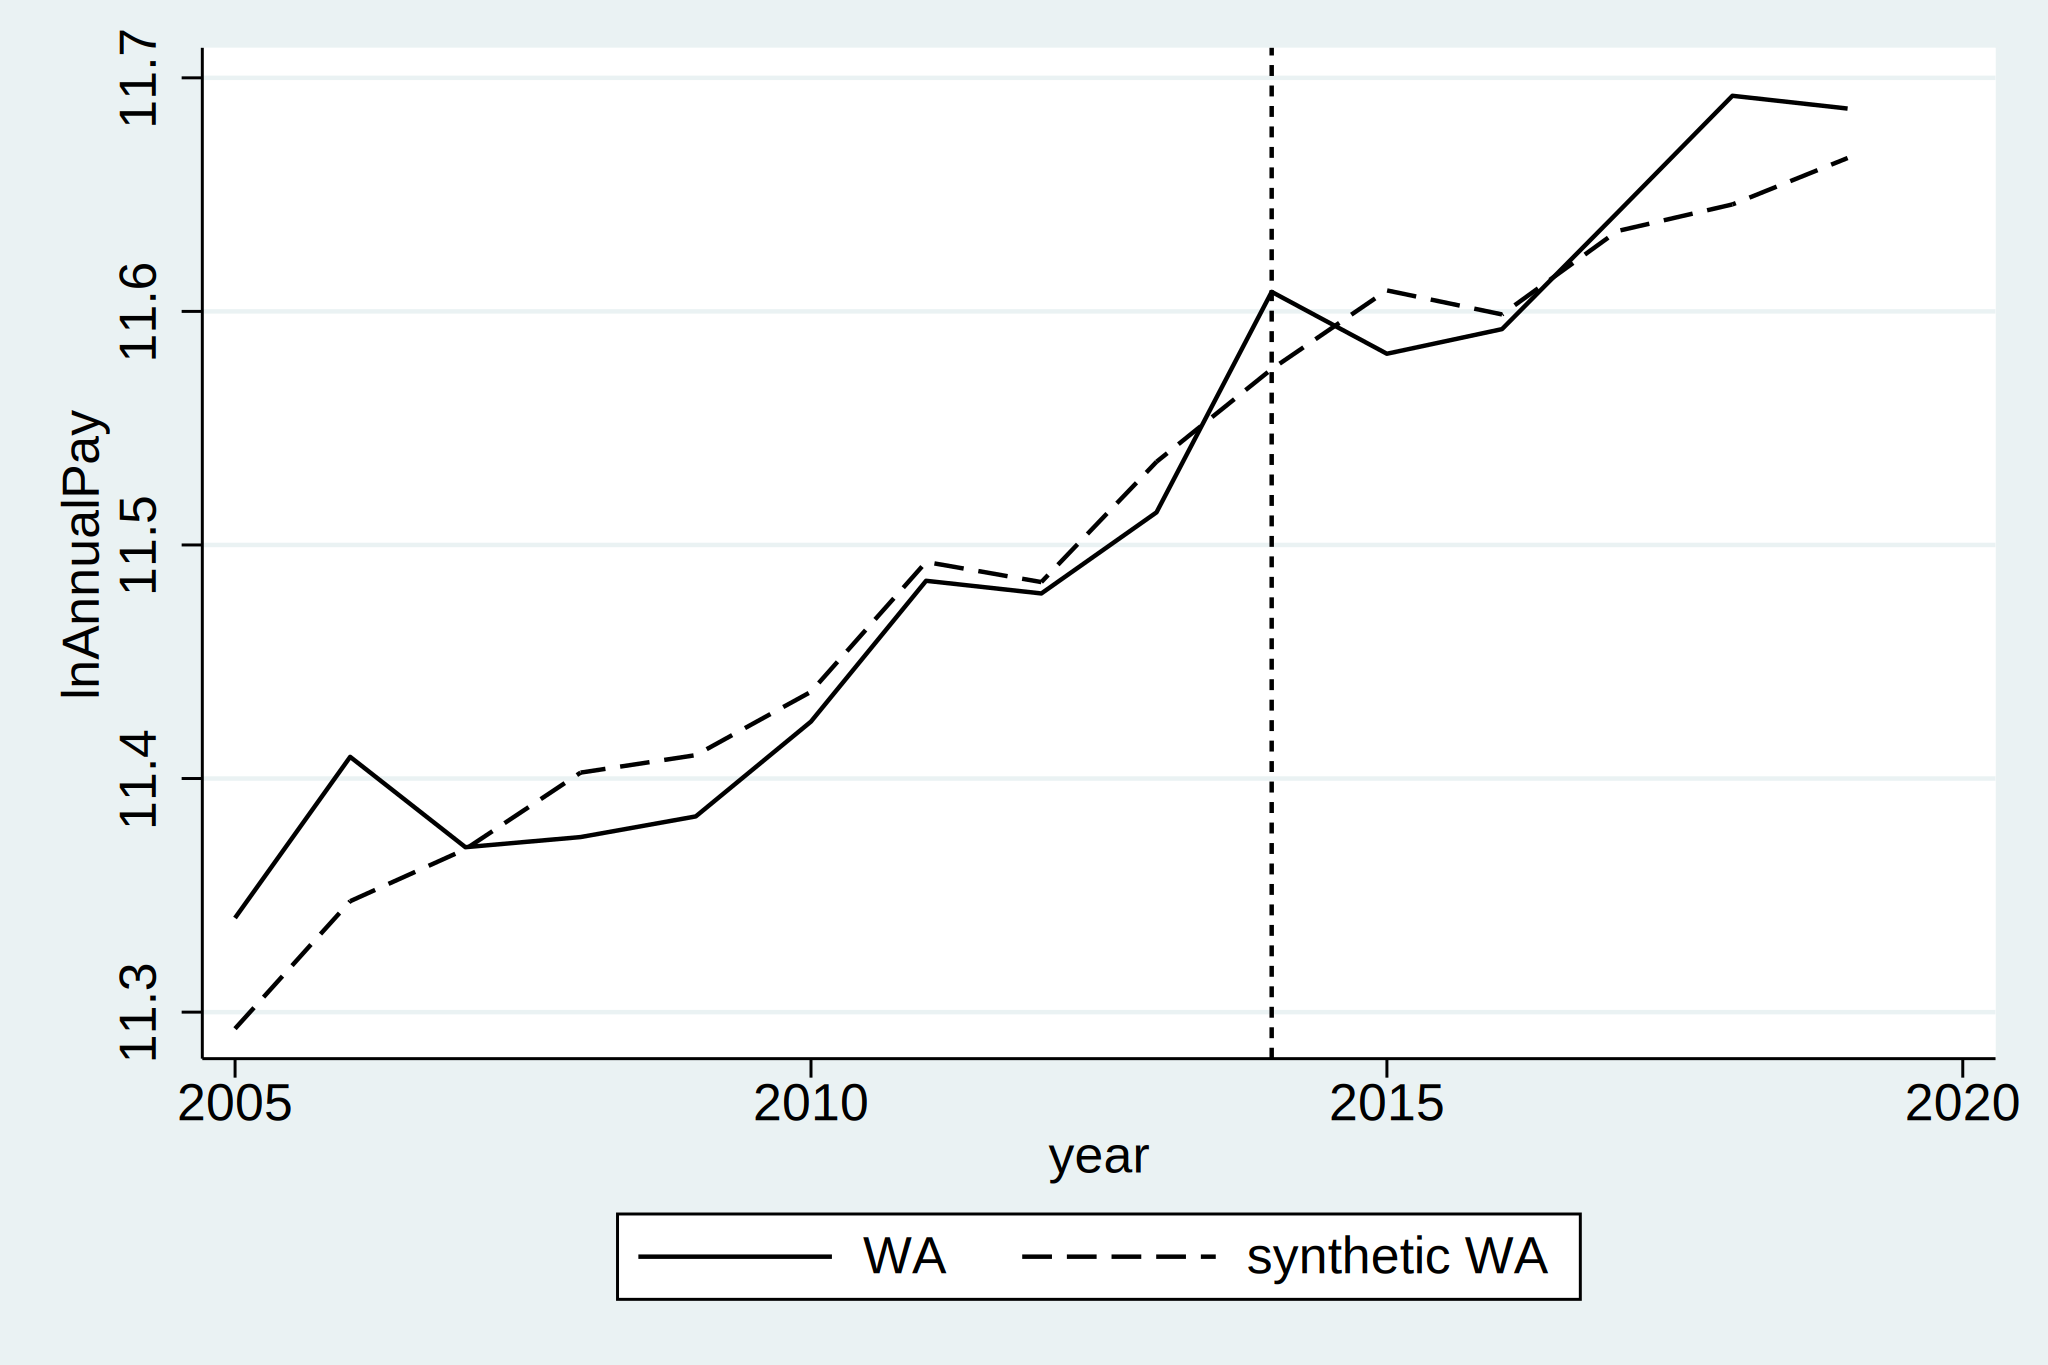

In [189]:
%%stata
/* Rename Graph */
graph rename Graph synthWaAnnualPayLn, replace

/*  Show the graph from the command above */
graph display

## Levels


. /* WA State is the treatment state.  WA is fips==53 */
. synth employment ///
>     employment(2010) employment(2011) employment(2012) employment(2013) ///
>     unemploy(2010) unemploy(2011) unemploy(2012) unemploy(2013) ///
>     pop, ///
>     trunit(53) trperiod(2014) unitnames(state) ///
>     msperiod(2005(1)2013) resultsperiod(2005(1)2019) ///
>     keep($synth/lvlEmploymentEst) replace ///
>     figure
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: WA
               Control Units: AL, AZ, AR, CA, CO, 

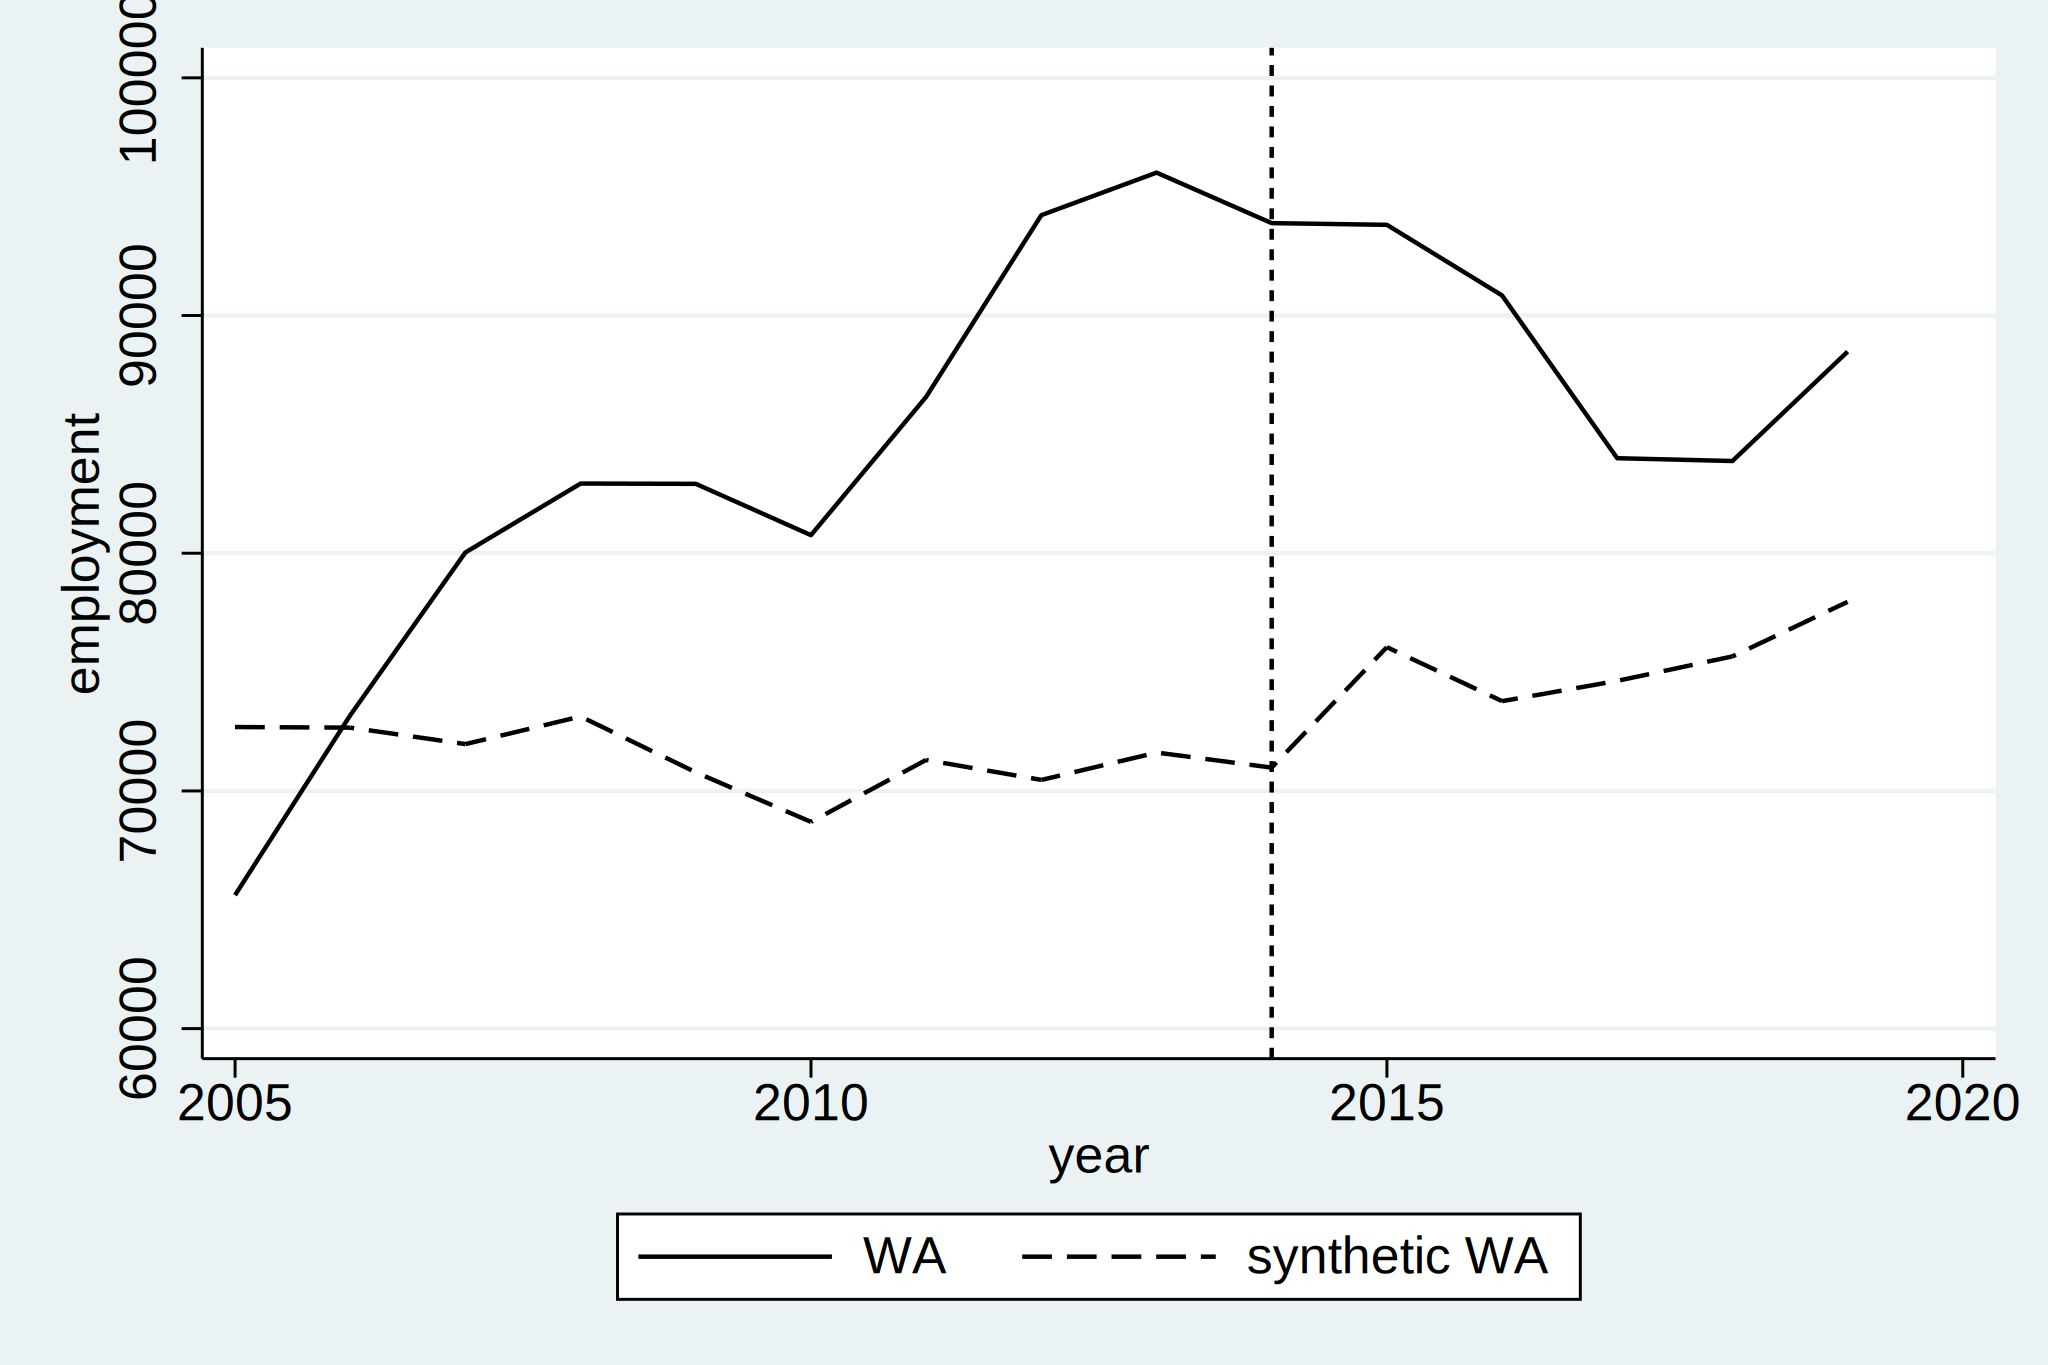

In [190]:
%%stata
/* WA State is the treatment state.  WA is fips==53 */
synth employment ///
    employment(2010) employment(2011) employment(2012) employment(2013) ///
    unemploy(2010) unemploy(2011) unemploy(2012) unemploy(2013) ///
    pop, ///
    trunit(53) trperiod(2014) unitnames(state) ///
    msperiod(2005(1)2013) resultsperiod(2005(1)2019) ///
    keep($synth/lvlEmploymentEst) replace ///
    figure

/* Store Predictor Estimates */
matrix synthMatEmploy = e(X_balance)


. synth annualPay ///
>     annualPay(2010) annualPay(2011) annualPay(2012) annualPay(2013) ///
>     unemploy(2010) unemploy(2011) unemploy(2012) unemploy(2013) ///
>     pop, ///
>     trunit(53) trperiod(2014) unitnames(state) ///
>     msperiod(2005(1)2013) resultsperiod(2005(1)2019) /// 
>     keep($synth/lvlAnnualPayEst) replace ///
>     figure
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: WA
               Control Units: AL, AZ, AR, CA, CO, CT, FL, GA, IL, IN, KS, KY,
                              MD, 

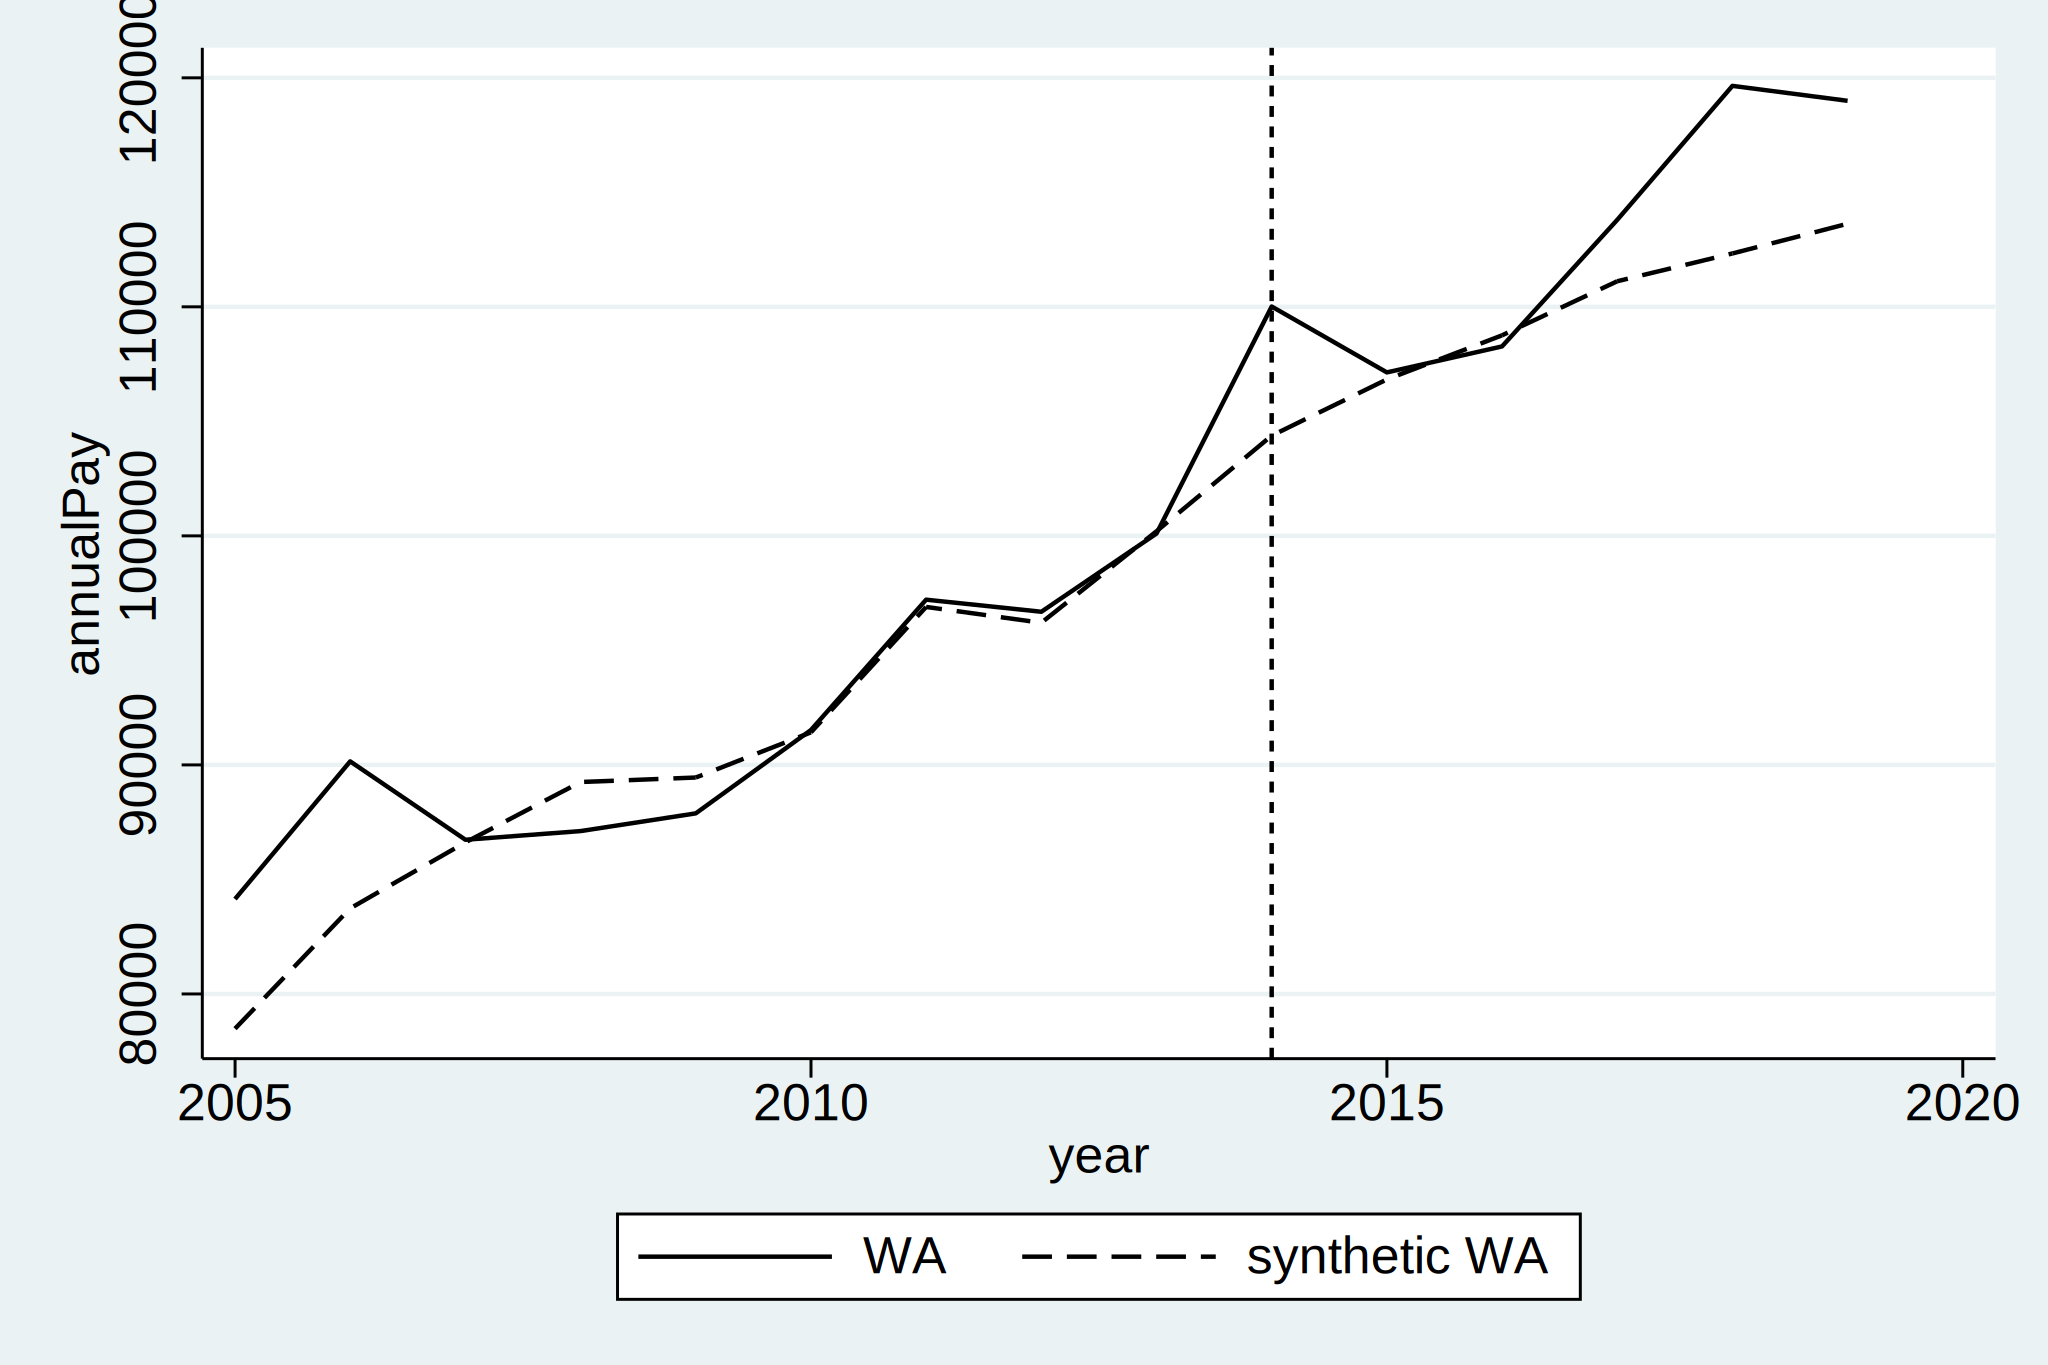

In [191]:
%%stata
synth annualPay ///
    annualPay(2010) annualPay(2011) annualPay(2012) annualPay(2013) ///
    unemploy(2010) unemploy(2011) unemploy(2012) unemploy(2013) ///
    pop, ///
    trunit(53) trperiod(2014) unitnames(state) ///
    msperiod(2005(1)2013) resultsperiod(2005(1)2019) /// 
    keep($synth/lvlAnnualPayEst) replace ///
    figure
    
/* Store Predictor Estimates */
matrix synthMatAnnualPay = e(X_balance)

In [192]:
%%stata
esttab matrix(synthMatEmploy, fmt(%12.2gc)), ///
    mtitles("Employment")
    
esttab matrix(synthMatAnnualPay, fmt(%12.2gc)), ///
    mtitles("Employment")


. esttab matrix(synthMatEmploy, fmt(%12.2gc)), ///
>     mtitles("Employment")

--------------------------------------
               Employment             
                  Treated    Synthetic
--------------------------------------
employ~2010)       80,762       68,699
employ~2011)       86,577       71,307
employ~2012)       94,224       70,465
employ~2013)       96,012       71,614
unempl~2010)          9.1           13
unempl~2011)          8.5           12
unempl~2012)          7.7           11
unempl~2013)          6.6            9
pop             6,638,867   36,981,387
--------------------------------------

.     
. esttab matrix(synthMatAnnualPay, fmt(%12.2gc)), ///
>     mtitles("Employment")

--------------------------------------
               Employment             
                  Treated    Synthetic
--------------------------------------
annual~2010)       91,526       91,424
annual~2011)       97,215       96,898
annual~2012)       96,688       96,209
annual~20

## Build Synthetic Plots for Report

In [193]:
%%stata
// Employment
use $synth/lvlEmploymentEst, clear
describe


. // Employment
. use $synth/lvlEmploymentEst, clear

. describe

Contains data from Data/Synth/lvlEmploymentEst.dta
 Observations:            33                  
    Variables:             5                  13 Feb 2022 14:31
-------------------------------------------------------------------------------
Variable      Storage   Display    Value
    name         type    format    label      Variable label
-------------------------------------------------------------------------------
_Co_Number      float   %9.0g      fips       Co_No
_W_Weight       float   %9.0g                 Unit_Weight
_Y_treated      double  %10.0g                WA
_Y_synthetic    double  %10.0g                synthetic WA
_time           double  %10.0g                
-------------------------------------------------------------------------------
Sorted by: 

. 



. // Plot Employment Synthetic Control
. twoway (line _Y_treated _time) ///
>        (line _Y_synthetic _time, lpattern(dash)), ///
>     xline(2014, lpattern(shortdash) lcolor(black))  ///
>     title("Synthetic Control: Aerospace Employment") ///
>     subtitle("NAICS 3364 - Aerospace Product and Parts Manufacturing") ///
>     ytitle(Annual Employment) ///
>     xtitle("Year") ///
>     legend( label(1 "WA") label(2 "Synthetic WA")) ///
>     graphregion(fcolor(white)) ///
>     ylabel(, format(%9.0gc)) ///
>     xlabel(2005(3)2020)

.     
. graph export $graphs/SynthEmployment.png, replace
file Output/Graphs/SynthEmployment.png written in PNG format

. 


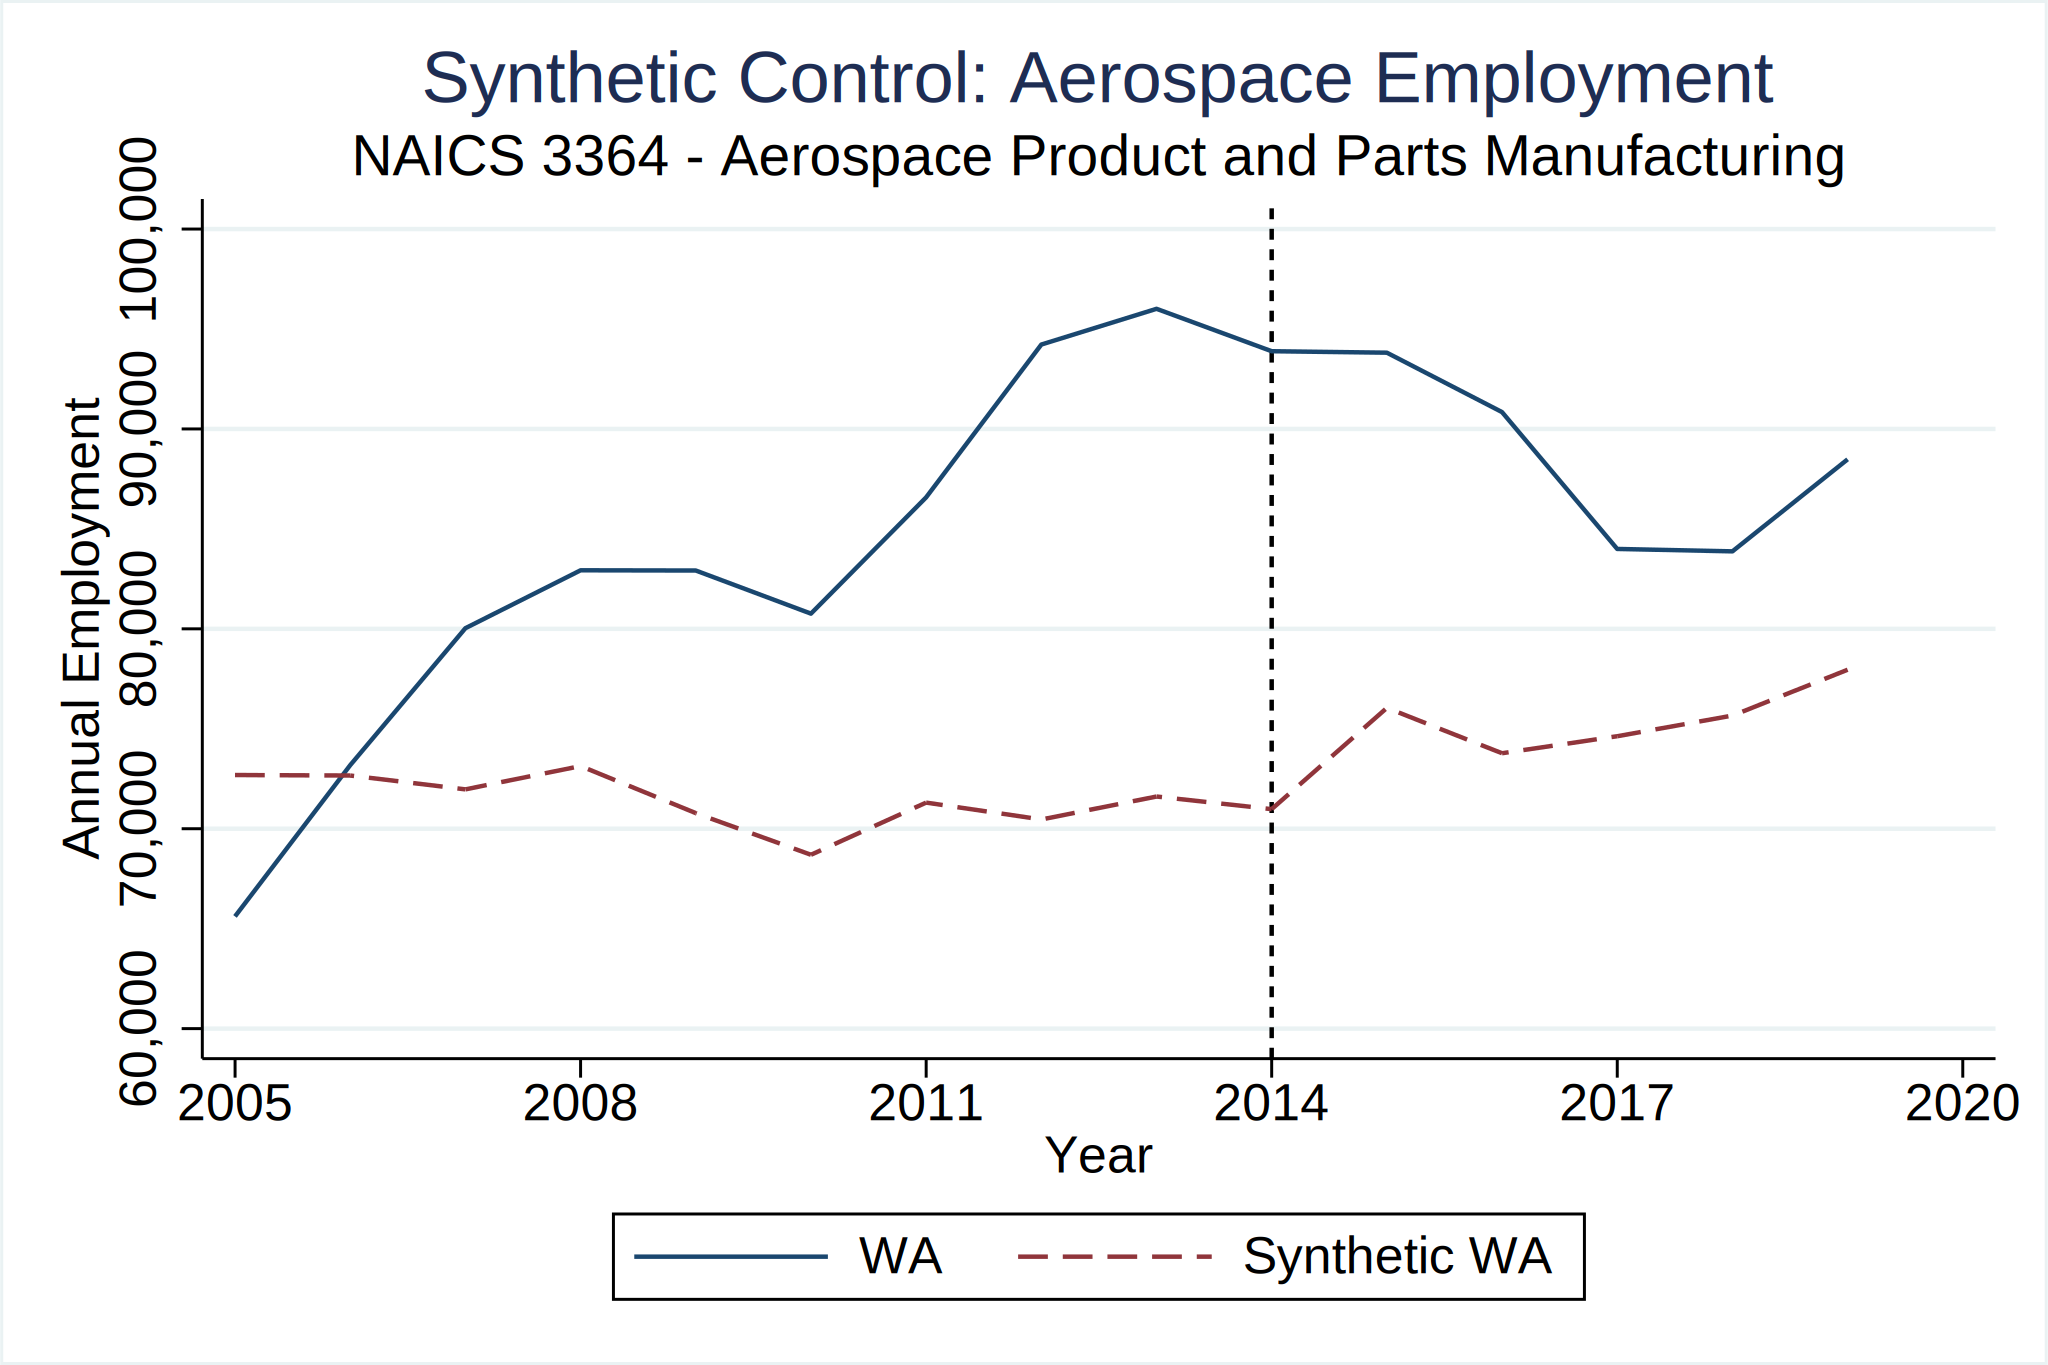

In [194]:
%%stata
// Plot Employment Synthetic Control
twoway (line _Y_treated _time) ///
       (line _Y_synthetic _time, lpattern(dash)), ///
    xline(2014, lpattern(shortdash) lcolor(black))  ///
    title("Synthetic Control: Aerospace Employment") ///
    subtitle("NAICS 3364 - Aerospace Product and Parts Manufacturing") ///
    ytitle(Annual Employment) ///
    xtitle("Year") ///
    legend( label(1 "WA") label(2 "Synthetic WA")) ///
    graphregion(fcolor(white)) ///
    ylabel(, format(%9.0gc)) ///
    xlabel(2005(3)2020)
    
graph export $graphs/SynthEmployment.png, replace

In [195]:
%%stata
// Annual Pay
use $synth/lvlAnnualPayEst, clear
describe


. // Annual Pay
. use $synth/lvlAnnualPayEst, clear

. describe

Contains data from Data/Synth/lvlAnnualPayEst.dta
 Observations:            33                  
    Variables:             5                  13 Feb 2022 14:31
-------------------------------------------------------------------------------
Variable      Storage   Display    Value
    name         type    format    label      Variable label
-------------------------------------------------------------------------------
_Co_Number      float   %9.0g      fips       Co_No
_W_Weight       float   %9.0g                 Unit_Weight
_Y_treated      double  %10.0g                WA
_Y_synthetic    double  %10.0g                synthetic WA
_time           double  %10.0g                
-------------------------------------------------------------------------------
Sorted by: 

. 



. // Plot Employment Synthetic Control
. twoway (line _Y_treated _time) ///
>        (line _Y_synthetic _time, lpattern(dash)), ///
>     xline(2014, lpattern(shortdash) lcolor(black))  ///
>     title("Synthetic Control: Aerospace Annual Pay") ///
>     subtitle("NAICS 3364 - Aerospace Product and Parts Manufacturing") ///
>     ytitle(Annual Pay) ///
>     xtitle("Year") ///
>     legend( label(1 "WA") label(2 "Synthetic WA")) ///
>     graphregion(fcolor(white)) ///
>     ylabel(#3, format(%9.0gc)) ymtick(##2) ///
>     xlabel(2005(3)2020)

.     
. graph export $graphs/SynthAnnualPay.png, replace
file Output/Graphs/SynthAnnualPay.png written in PNG format

. 


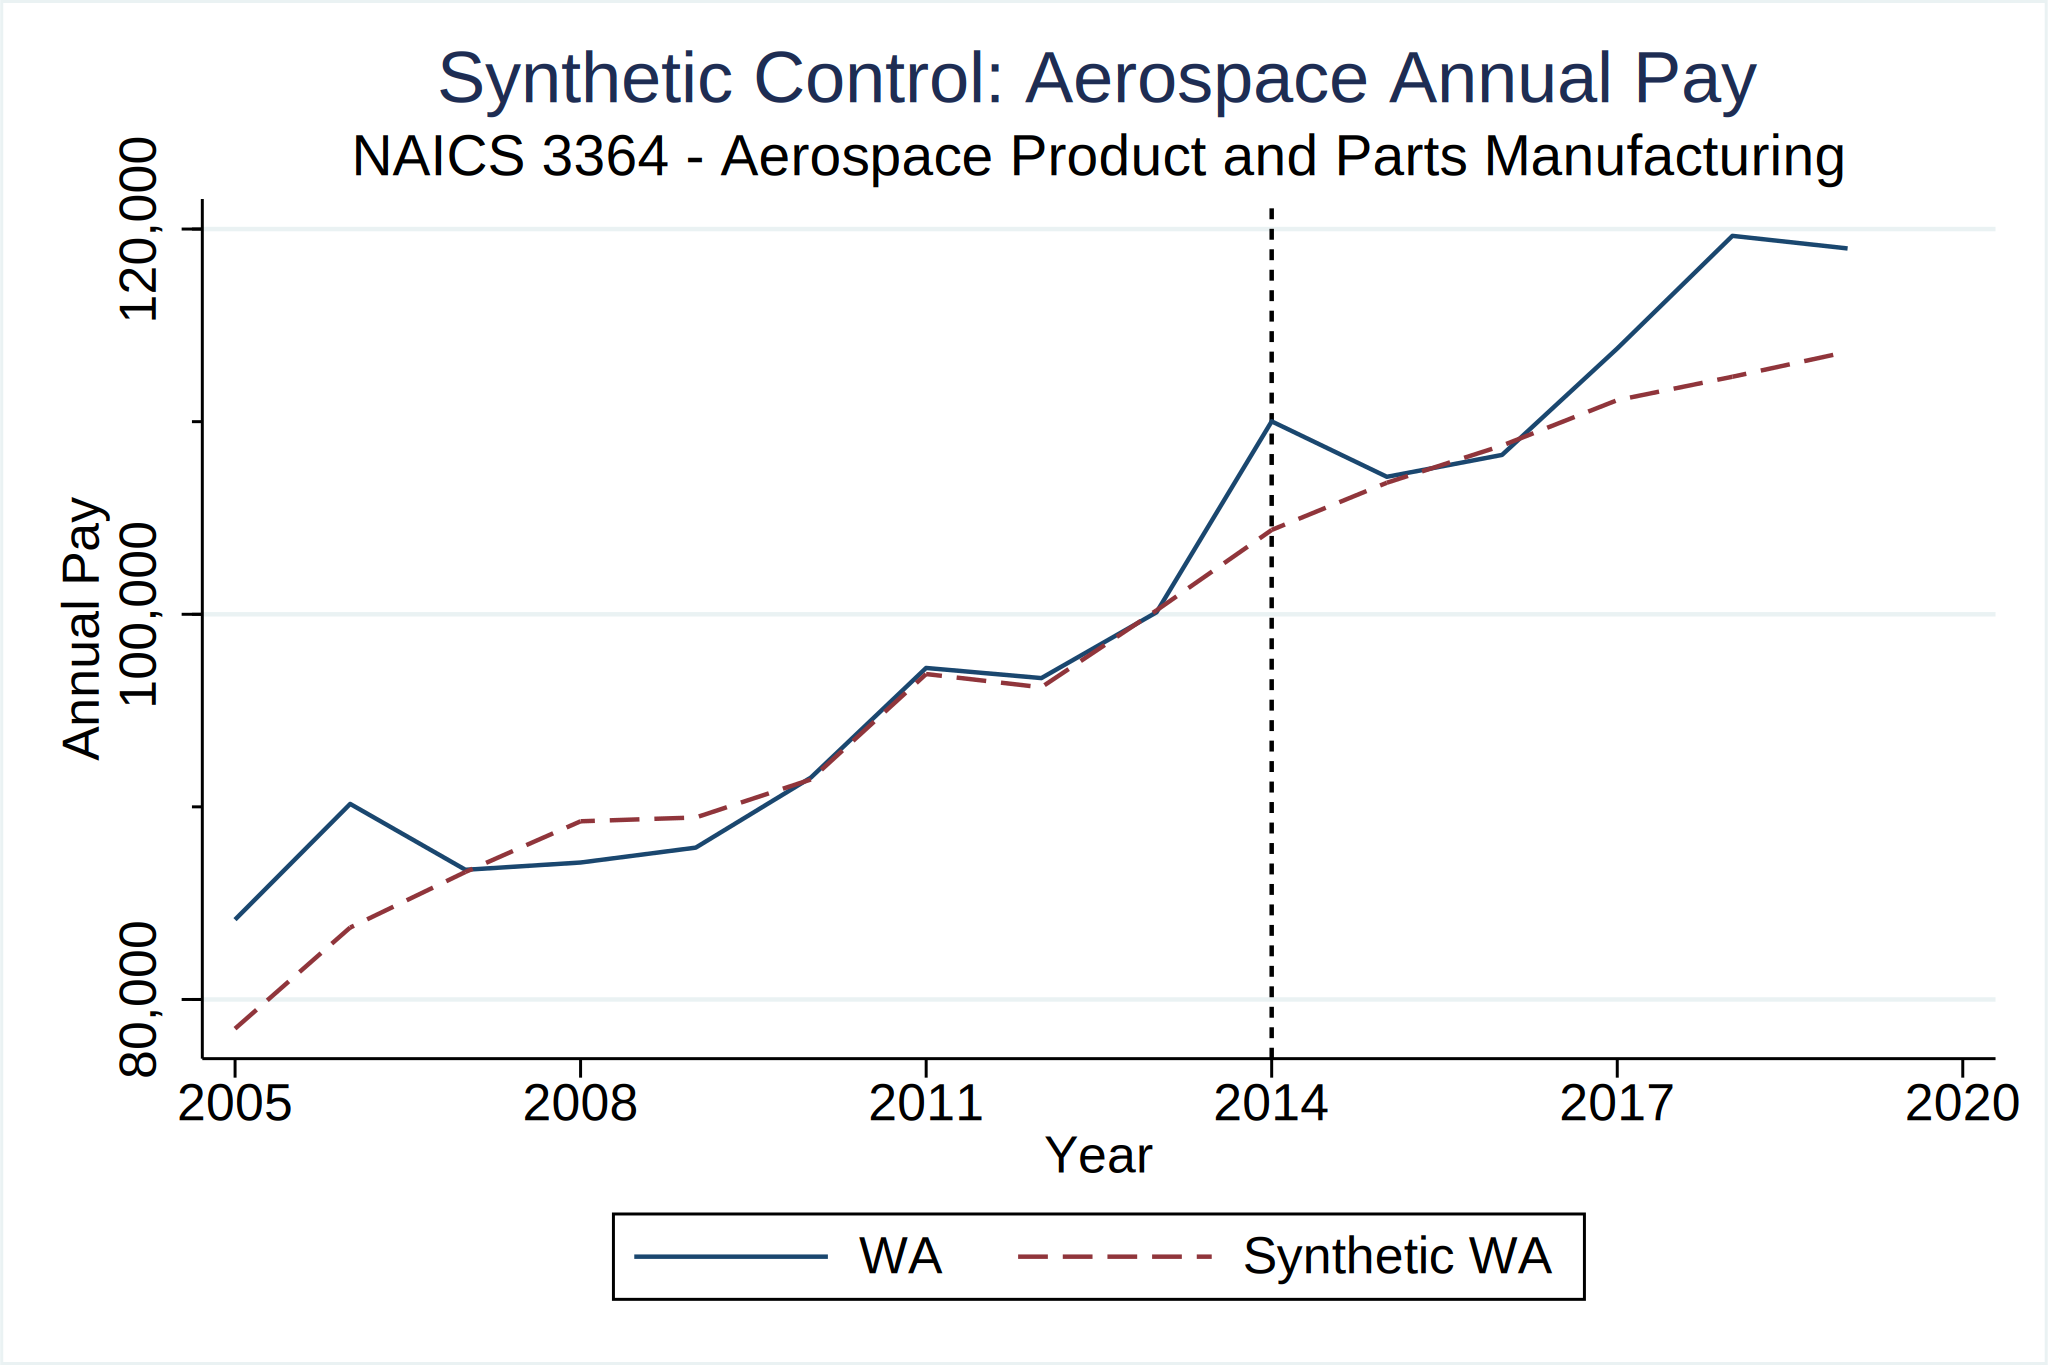

In [196]:
%%stata
// Plot Employment Synthetic Control
twoway (line _Y_treated _time) ///
       (line _Y_synthetic _time, lpattern(dash)), ///
    xline(2014, lpattern(shortdash) lcolor(black))  ///
    title("Synthetic Control: Aerospace Annual Pay") ///
    subtitle("NAICS 3364 - Aerospace Product and Parts Manufacturing") ///
    ytitle(Annual Pay) ///
    xtitle("Year") ///
    legend( label(1 "WA") label(2 "Synthetic WA")) ///
    graphregion(fcolor(white)) ///
    ylabel(#3, format(%9.0gc)) ymtick(##2) ///
    xlabel(2005(3)2020)
    
graph export $graphs/SynthAnnualPay.png, replace

## Placebo Test for Annual Pay


. local statelist 1 4 5 6 8 9 12 13 17 18 20 21 24 25 26 28 ///
>     29 33 34 35 36 37 39 40 41 42 45 47 48 49 51 53 54 55

.     
. // Generate Counterfactuals
. foreach i of local statelist{
  2.     use "$finalSynthData" if year>2004, clear
  3.     synth annualPay ///
>     annualPay(2010) annualPay(2011) annualPay(2012) annualPay(2013) ///
>     unemploy(2010) unemploy(2011) unemploy(2012) unemploy(2013) ///
>     pop, ///
>     trunit(`i') trperiod(2014) unitnames(state) ///
>     msperiod(2005(1)2013) resultsperiod(2005(1)2019) /// 
>     keep($placebo/lvlAnnualPayEst_`i') replace ///
>     figure
  4.     
.     use $placebo/lvlAnnualPayEst_`i', clear
  5. 
.     keep _Y_treated _Y_synthetic _time
  6. 
.     drop if _time == . 
  7.     rename _time year 
  8.     rename _Y_treated treat`i'
  9.     rename _Y_synthetic counterfactual`i'
 10.     gen gap`i' = treat - counterfactual`i'
 11.     sort year
 12.          
.     save $placebo/lvlAnnualPayEst_`i', replace 
 13. }
-

(18 observations deleted)
file Data/Synth/Placebo/lvlAnnualPayEst_4.dta saved
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: AR
               Control Units: AL, AZ, CA, CO, CT, FL, GA, IL, IN, KS, KY, MD,
                              MA, MI, MS, MO, NH, NJ, NM, NY, NC, OH, OK, OR,
                              PA, SC, TN, TX, UT, VA, WA, WV, WI
-------------------------------------------------------------------------------
          Dependent Variable: annualPay
  MSPE minimized for periods: 2005 2006 2007 200

(18 observations deleted)
file Data/Synth/Placebo/lvlAnnualPayEst_6.dta saved
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: CO
               Control Units: AL, AZ, AR, CA, CT, FL, GA, IL, IN, KS, KY, MD,
                              MA, MI, MS, MO, NH, NJ, NM, NY, NC, OH, OK, OR,
                              PA, SC, TN, TX, UT, VA, WA, WV, WI
-------------------------------------------------------------------------------
          Dependent Variable: annualPay
  MSPE minimized for periods: 2005 2006 2007 200

(18 observations deleted)
file Data/Synth/Placebo/lvlAnnualPayEst_9.dta saved
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: FL
               Control Units: AL, AZ, AR, CA, CO, CT, GA, IL, IN, KS, KY, MD,
                              MA, MI, MS, MO, NH, NJ, NM, NY, NC, OH, OK, OR,
                              PA, SC, TN, TX, UT, VA, WA, WV, WI
-------------------------------------------------------------------------------
          Dependent Variable: annualPay
  MSPE minimized for periods: 2005 2006 2007 200

(18 observations deleted)
file Data/Synth/Placebo/lvlAnnualPayEst_13.dta saved
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: IL
               Control Units: AL, AZ, AR, CA, CO, CT, FL, GA, IN, KS, KY, MD,
                              MA, MI, MS, MO, NH, NJ, NM, NY, NC, OH, OK, OR,
                              PA, SC, TN, TX, UT, VA, WA, WV, WI
-------------------------------------------------------------------------------
          Dependent Variable: annualPay
  MSPE minimized for periods: 2005 2006 2007 20

(18 observations deleted)
file Data/Synth/Placebo/lvlAnnualPayEst_18.dta saved
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: KS
               Control Units: AL, AZ, AR, CA, CO, CT, FL, GA, IL, IN, KY, MD,
                              MA, MI, MS, MO, NH, NJ, NM, NY, NC, OH, OK, OR,
                              PA, SC, TN, TX, UT, VA, WA, WV, WI
-------------------------------------------------------------------------------
          Dependent Variable: annualPay
  MSPE minimized for periods: 2005 2006 2007 20

(18 observations deleted)
file Data/Synth/Placebo/lvlAnnualPayEst_21.dta saved
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: MD
               Control Units: AL, AZ, AR, CA, CO, CT, FL, GA, IL, IN, KS, KY,
                              MA, MI, MS, MO, NH, NJ, NM, NY, NC, OH, OK, OR,
                              PA, SC, TN, TX, UT, VA, WA, WV, WI
-------------------------------------------------------------------------------
          Dependent Variable: annualPay
  MSPE minimized for periods: 2005 2006 2007 20

(18 observations deleted)
file Data/Synth/Placebo/lvlAnnualPayEst_25.dta saved
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: MI
               Control Units: AL, AZ, AR, CA, CO, CT, FL, GA, IL, IN, KS, KY,
                              MD, MA, MS, MO, NH, NJ, NM, NY, NC, OH, OK, OR,
                              PA, SC, TN, TX, UT, VA, WA, WV, WI
-------------------------------------------------------------------------------
          Dependent Variable: annualPay
  MSPE minimized for periods: 2005 2006 2007 20

(18 observations deleted)
file Data/Synth/Placebo/lvlAnnualPayEst_28.dta saved
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: MO
               Control Units: AL, AZ, AR, CA, CO, CT, FL, GA, IL, IN, KS, KY,
                              MD, MA, MI, MS, NH, NJ, NM, NY, NC, OH, OK, OR,
                              PA, SC, TN, TX, UT, VA, WA, WV, WI
-------------------------------------------------------------------------------
          Dependent Variable: annualPay
  MSPE minimized for periods: 2005 2006 2007 20

(18 observations deleted)
file Data/Synth/Placebo/lvlAnnualPayEst_33.dta saved
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: NJ
               Control Units: AL, AZ, AR, CA, CO, CT, FL, GA, IL, IN, KS, KY,
                              MD, MA, MI, MS, MO, NH, NM, NY, NC, OH, OK, OR,
                              PA, SC, TN, TX, UT, VA, WA, WV, WI
-------------------------------------------------------------------------------
          Dependent Variable: annualPay
  MSPE minimized for periods: 2005 2006 2007 20

(18 observations deleted)
file Data/Synth/Placebo/lvlAnnualPayEst_35.dta saved
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: NY
               Control Units: AL, AZ, AR, CA, CO, CT, FL, GA, IL, IN, KS, KY,
                              MD, MA, MI, MS, MO, NH, NJ, NM, NC, OH, OK, OR,
                              PA, SC, TN, TX, UT, VA, WA, WV, WI
-------------------------------------------------------------------------------
          Dependent Variable: annualPay
  MSPE minimized for periods: 2005 2006 2007 20

(18 observations deleted)
file Data/Synth/Placebo/lvlAnnualPayEst_37.dta saved
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: OH
               Control Units: AL, AZ, AR, CA, CO, CT, FL, GA, IL, IN, KS, KY,
                              MD, MA, MI, MS, MO, NH, NJ, NM, NY, NC, OK, OR,
                              PA, SC, TN, TX, UT, VA, WA, WV, WI
-------------------------------------------------------------------------------
          Dependent Variable: annualPay
  MSPE minimized for periods: 2005 2006 2007 20

(18 observations deleted)
file Data/Synth/Placebo/lvlAnnualPayEst_40.dta saved
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: OR
               Control Units: AL, AZ, AR, CA, CO, CT, FL, GA, IL, IN, KS, KY,
                              MD, MA, MI, MS, MO, NH, NJ, NM, NY, NC, OH, OK,
                              PA, SC, TN, TX, UT, VA, WA, WV, WI
-------------------------------------------------------------------------------
          Dependent Variable: annualPay
  MSPE minimized for periods: 2005 2006 2007 20

(18 observations deleted)
file Data/Synth/Placebo/lvlAnnualPayEst_42.dta saved
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: SC
               Control Units: AL, AZ, AR, CA, CO, CT, FL, GA, IL, IN, KS, KY,
                              MD, MA, MI, MS, MO, NH, NJ, NM, NY, NC, OH, OK,
                              OR, PA, TN, TX, UT, VA, WA, WV, WI
-------------------------------------------------------------------------------
          Dependent Variable: annualPay
  MSPE minimized for periods: 2005 2006 2007 20

(18 observations deleted)
file Data/Synth/Placebo/lvlAnnualPayEst_47.dta saved
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: TX
               Control Units: AL, AZ, AR, CA, CO, CT, FL, GA, IL, IN, KS, KY,
                              MD, MA, MI, MS, MO, NH, NJ, NM, NY, NC, OH, OK,
                              OR, PA, SC, TN, UT, VA, WA, WV, WI
-------------------------------------------------------------------------------
          Dependent Variable: annualPay
  MSPE minimized for periods: 2005 2006 2007 20

(18 observations deleted)
file Data/Synth/Placebo/lvlAnnualPayEst_49.dta saved
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: VA
               Control Units: AL, AZ, AR, CA, CO, CT, FL, GA, IL, IN, KS, KY,
                              MD, MA, MI, MS, MO, NH, NJ, NM, NY, NC, OH, OK,
                              OR, PA, SC, TN, TX, UT, WA, WV, WI
-------------------------------------------------------------------------------
          Dependent Variable: annualPay
  MSPE minimized for periods: 2005 2006 2007 20

(18 observations deleted)
file Data/Synth/Placebo/lvlAnnualPayEst_53.dta saved
-------------------------------------------------------------------------------
Synthetic Control Method for Comparative Case Studies
-------------------------------------------------------------------------------

First Step: Data Setup
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
Data Setup successful
-------------------------------------------------------------------------------
                Treated Unit: WV
               Control Units: AL, AZ, AR, CA, CO, CT, FL, GA, IL, IN, KS, KY,
                              MD, MA, MI, MS, MO, NH, NJ, NM, NY, NC, OH, OK,
                              OR, PA, SC, TN, TX, UT, VA, WA, WI
-------------------------------------------------------------------------------
          Dependent Variable: annualPay
  MSPE minimized for periods: 2005 2006 2007 20

(18 observations deleted)
file Data/Synth/Placebo/lvlAnnualPayEst_55.dta saved

. 
. /* Merge all the data together */
. // WA is FIPS 53
. use $placebo/lvlAnnualPayEst_53, clear

. foreach i of local statelist {
  2. 
.     merge 1:1 year using $placebo/lvlAnnualPayEst_`i'
  3.     drop _merge 
  4.     sort year 
  5.     
.     save $placebo/placebo_LvlAnnualPay.dta, replace
  6.     
. }

    Result                      Number of obs
    -----------------------------------------
    Not matched                             0
    Matched                                15  (_merge==3)
    -----------------------------------------
file Data/Synth/Placebo/placebo_LvlAnnualPay.dta saved

    Result                      Number of obs
    -----------------------------------------
    Not matched                             0
    Matched                                15  (_merge==3)
    -----------------------------------------
file Data/Synth/Placebo/placebo_LvlAnnualPay.dta saved

    Re


    Result                      Number of obs
    -----------------------------------------
    Not matched                             0
    Matched                                15  (_merge==3)
    -----------------------------------------
file Data/Synth/Placebo/placebo_LvlAnnualPay.dta saved

    Result                      Number of obs
    -----------------------------------------
    Not matched                             0
    Matched                                15  (_merge==3)
    -----------------------------------------
file Data/Synth/Placebo/placebo_LvlAnnualPay.dta saved

    Result                      Number of obs
    -----------------------------------------
    Not matched                             0
    Matched                                15  (_merge==3)
    -----------------------------------------
file Data/Synth/Placebo/placebo_LvlAnnualPay.dta saved

    Result                      Number of obs
    -----------------------------------------
    Not ma

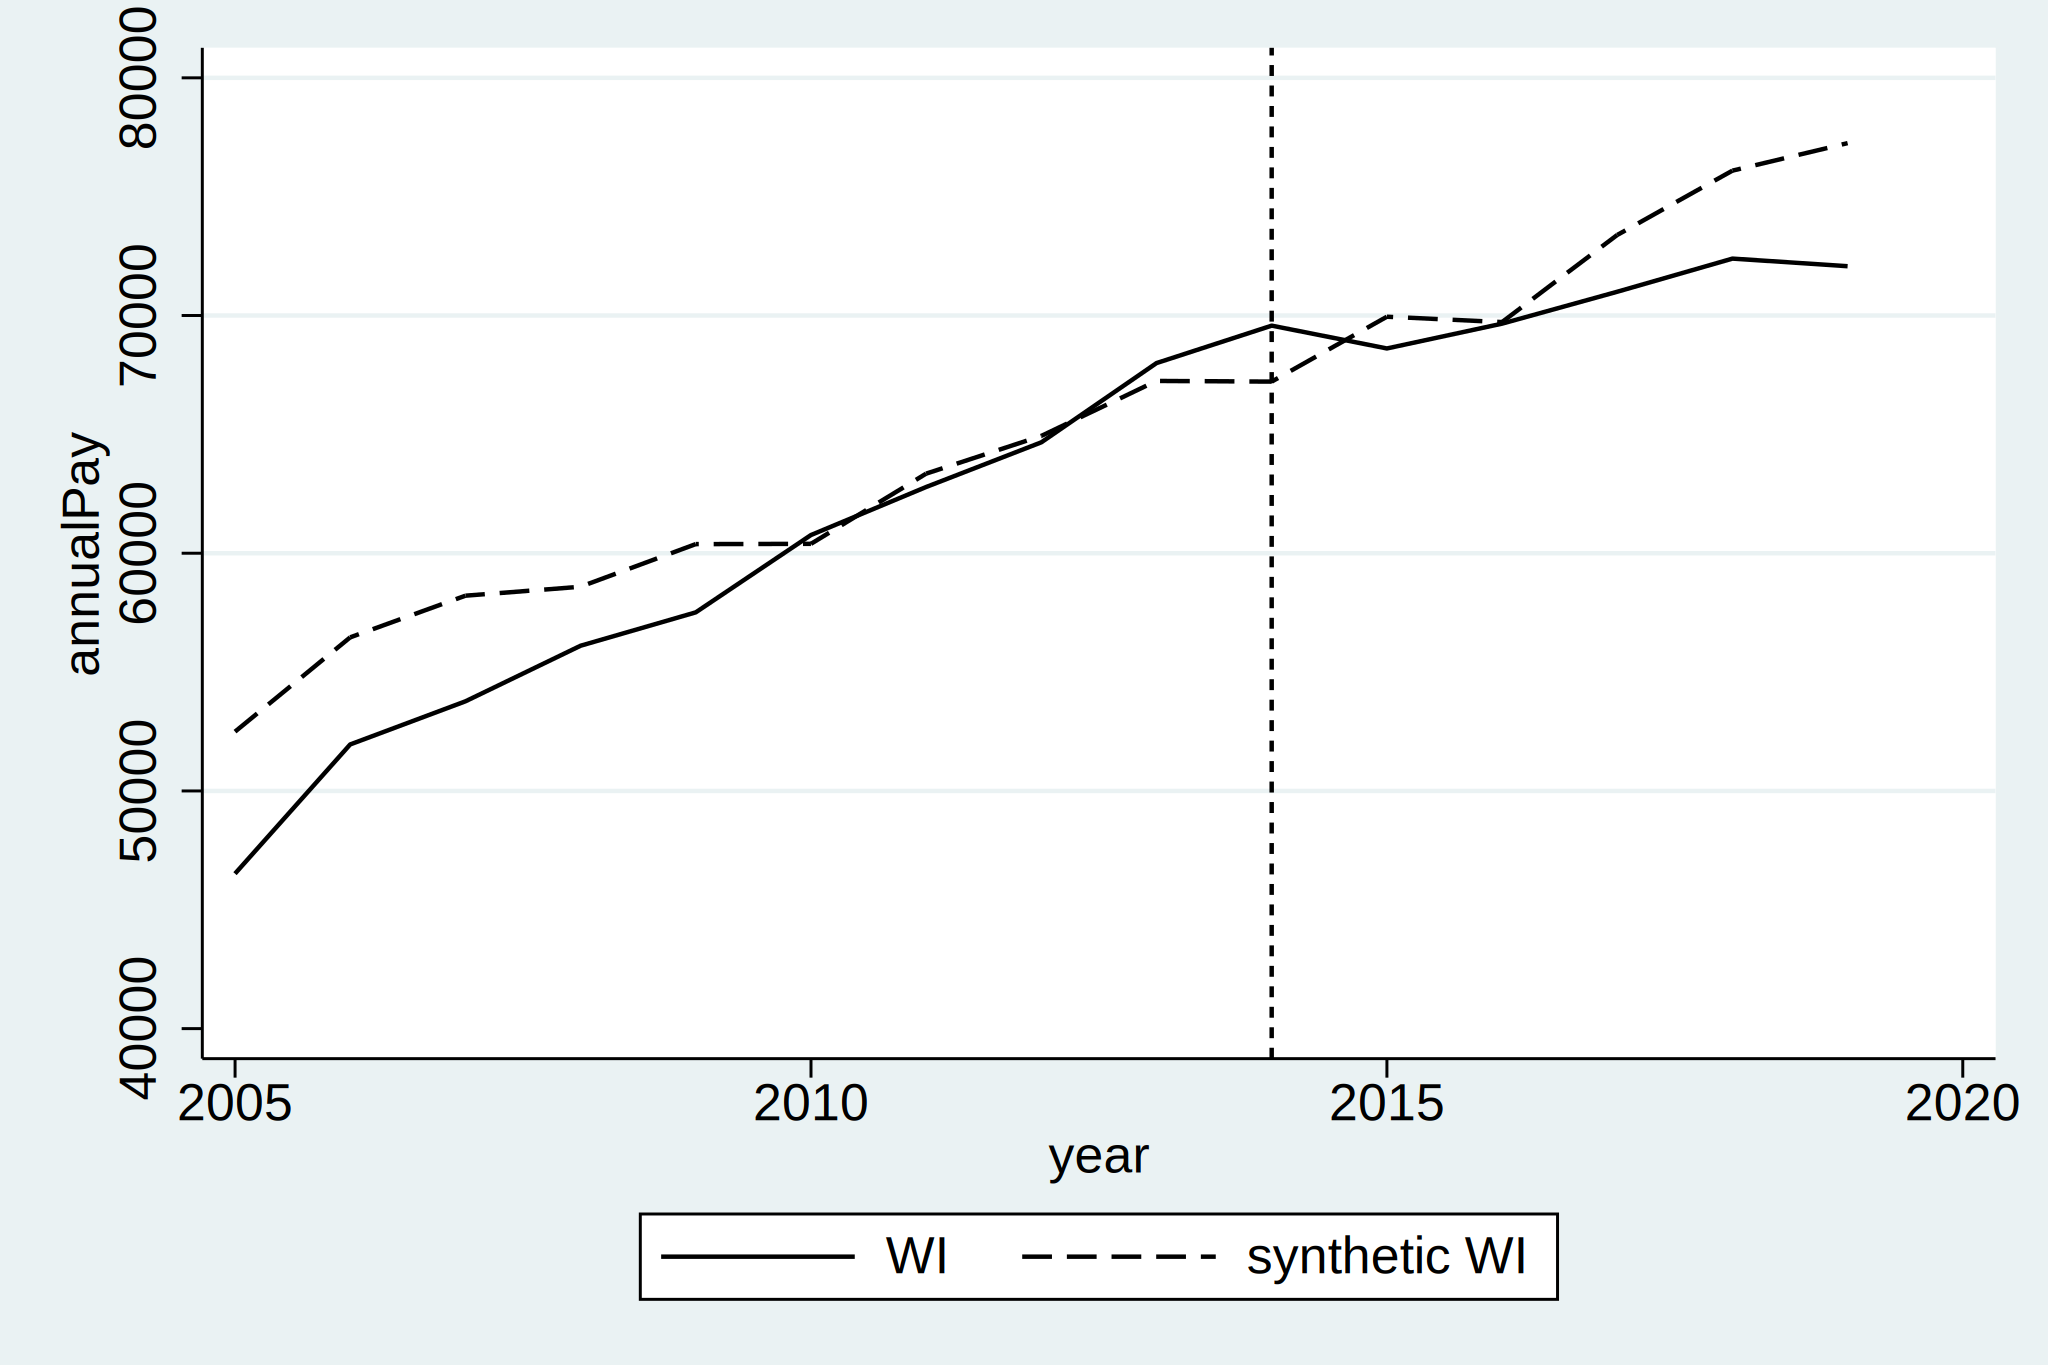

In [197]:
%%stata
local statelist 1 4 5 6 8 9 12 13 17 18 20 21 24 25 26 28 ///
    29 33 34 35 36 37 39 40 41 42 45 47 48 49 51 53 54 55
    
// Generate Counterfactuals
foreach i of local statelist{
    use "$finalSynthData" if year>2004, clear
    synth annualPay ///
    annualPay(2010) annualPay(2011) annualPay(2012) annualPay(2013) ///
    unemploy(2010) unemploy(2011) unemploy(2012) unemploy(2013) ///
    pop, ///
    trunit(`i') trperiod(2014) unitnames(state) ///
    msperiod(2005(1)2013) resultsperiod(2005(1)2019) /// 
    keep($placebo/lvlAnnualPayEst_`i') replace ///
    figure
    
    use $placebo/lvlAnnualPayEst_`i', clear

    keep _Y_treated _Y_synthetic _time

    drop if _time == . 
    rename _time year 
    rename _Y_treated treat`i'
    rename _Y_synthetic counterfactual`i'
    gen gap`i' = treat - counterfactual`i'
    sort year
         
    save $placebo/lvlAnnualPayEst_`i', replace 
}

/* Merge all the data together */
// WA is FIPS 53
use $placebo/lvlAnnualPayEst_53, clear
foreach i of local statelist {

    merge 1:1 year using $placebo/lvlAnnualPayEst_`i'
    drop _merge 
    sort year 
    
    save $placebo/placebo_LvlAnnualPay.dta, replace
    
}


. use  $placebo/placebo_LvlAnnualPay.dta,clear

. 
. /* Plot the Placebo Chart */
. graph twoway ///
>     (line gap1 year, lp(solid) lw(vthin)) ///
>     (line gap4 year, lp(solid) lw(vthin)) ///
>     (line gap5 year, lp(solid) lw(vthin)) ///
>     (line gap6 year, lp(solid) lw(vthin)) ///
>     (line gap8 year, lp(solid) lw(vthin)) ///
>     (line gap9 year, lp(solid) lw(vthin)) ///
>     (line gap12 year, lp(solid) lw(vthin)) ///
>     (line gap13 year, lp(solid) lw(vthin)) ///
>     (line gap17 year, lp(solid) lw(vthin)) ///
>     (line gap18 year, lp(solid) lw(vthin)) ///
>     (line gap20 year, lp(solid) lw(vthin)) ///
>     (line gap21 year, lp(solid) lw(vthin)) ///
>     (line gap24 year, lp(solid) lw(vthin)) ///
>     (line gap25 year, lp(solid) lw(vthin)) ///
>     (line gap26 year, lp(solid) lw(vthin)) ///
>     (line gap28 year, lp(solid) lw(vthin)) ///
>     (line gap29 year, lp(solid) lw(vthin)) ///
>     (line gap33 year, lp(solid) lw(vthin)) ///
>     (line gap34 year

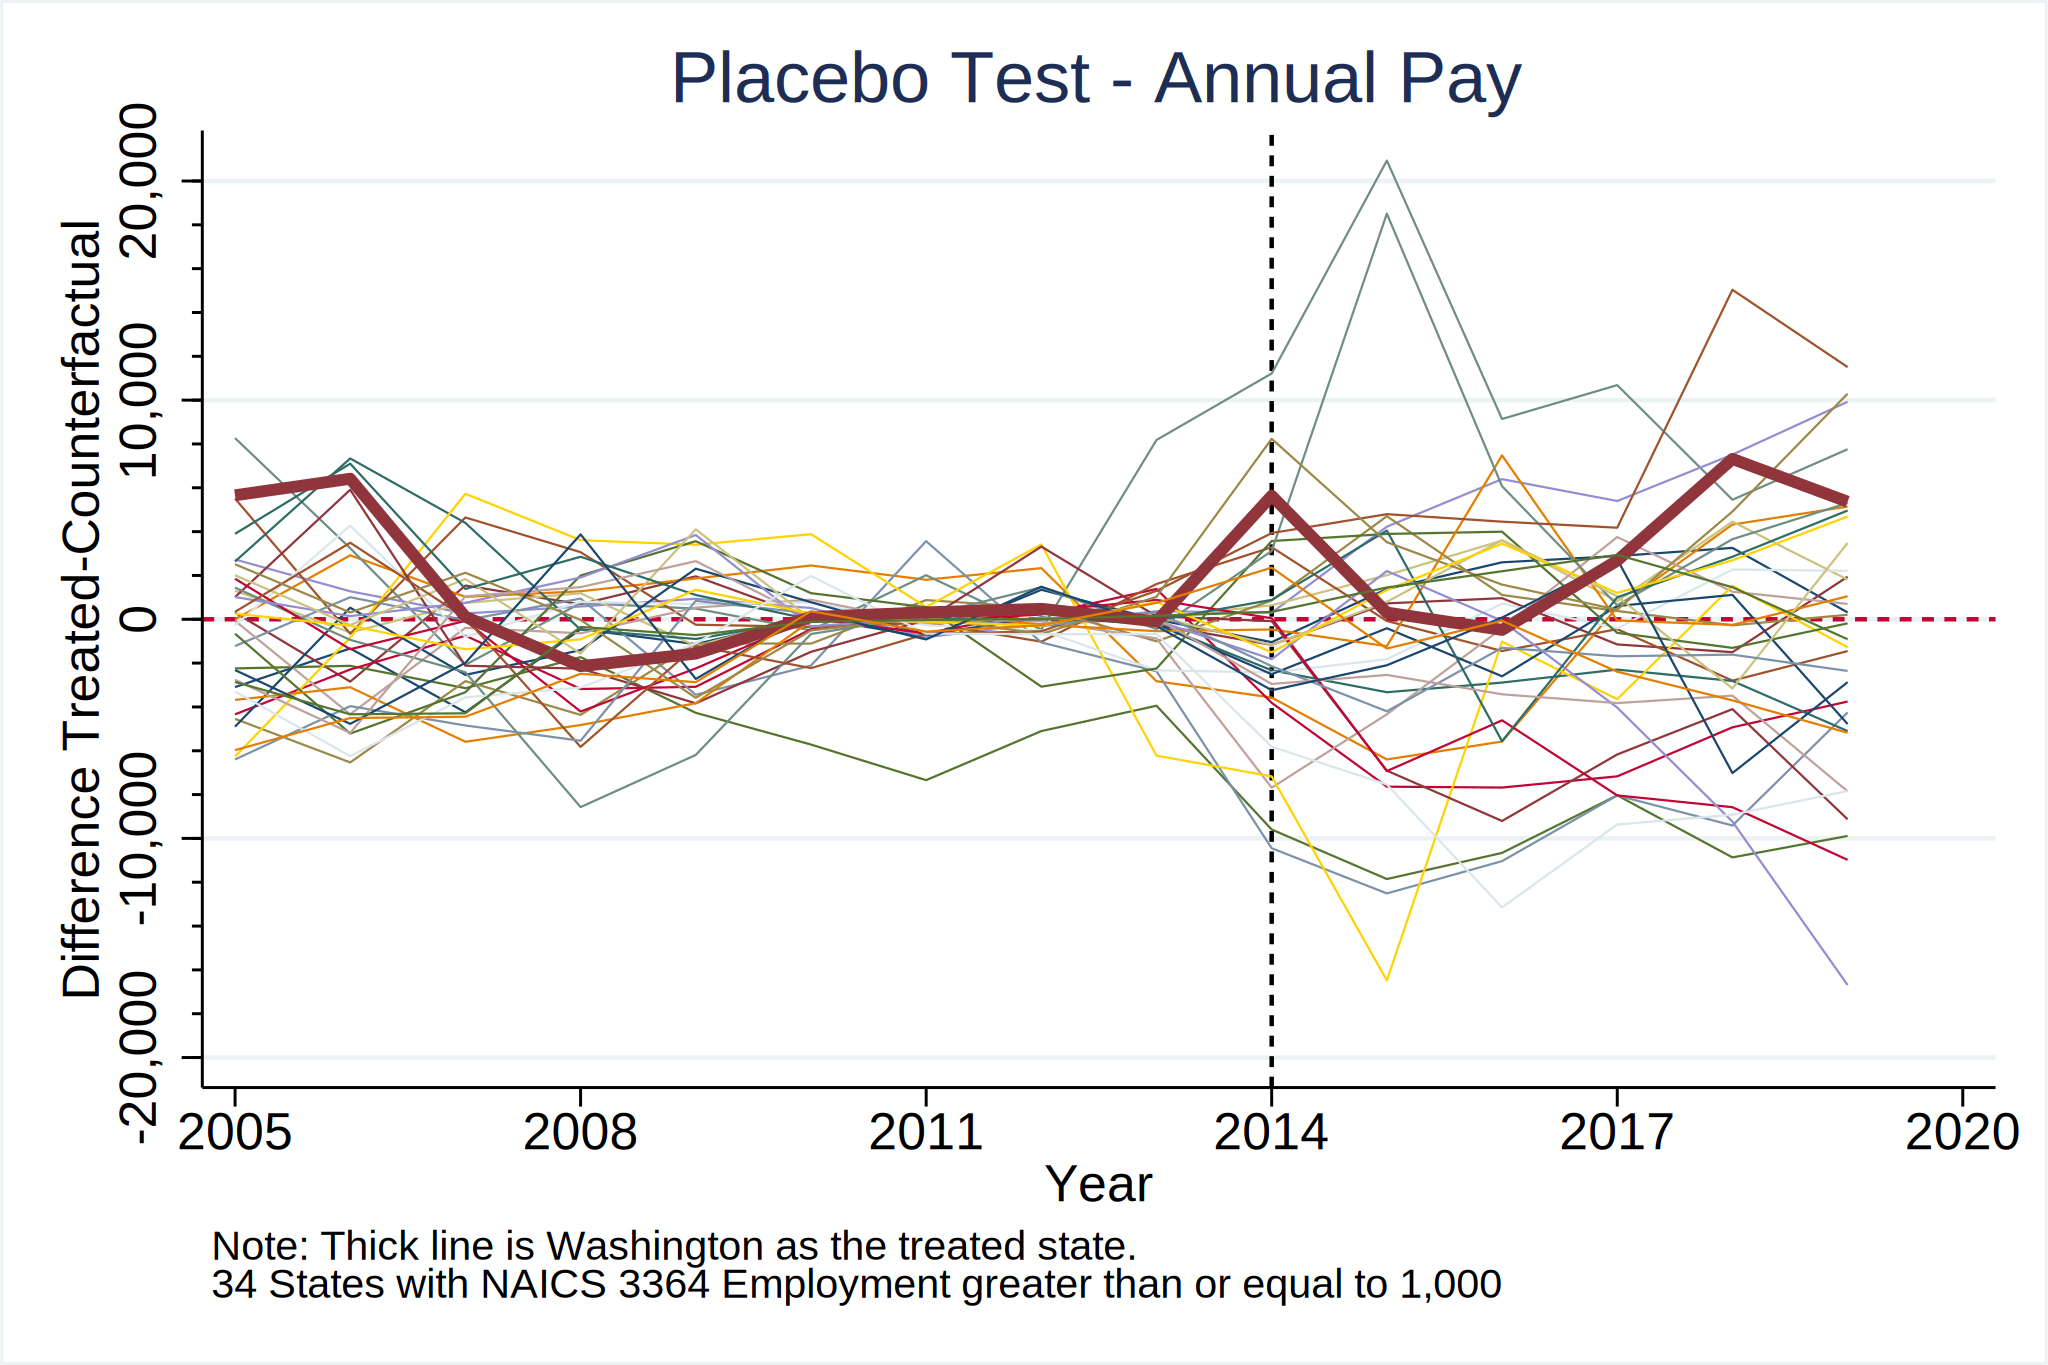

In [198]:
%%stata
use  $placebo/placebo_LvlAnnualPay.dta,clear

/* Plot the Placebo Chart */
graph twoway ///
    (line gap1 year, lp(solid) lw(vthin)) ///
    (line gap4 year, lp(solid) lw(vthin)) ///
    (line gap5 year, lp(solid) lw(vthin)) ///
    (line gap6 year, lp(solid) lw(vthin)) ///
    (line gap8 year, lp(solid) lw(vthin)) ///
    (line gap9 year, lp(solid) lw(vthin)) ///
    (line gap12 year, lp(solid) lw(vthin)) ///
    (line gap13 year, lp(solid) lw(vthin)) ///
    (line gap17 year, lp(solid) lw(vthin)) ///
    (line gap18 year, lp(solid) lw(vthin)) ///
    (line gap20 year, lp(solid) lw(vthin)) ///
    (line gap21 year, lp(solid) lw(vthin)) ///
    (line gap24 year, lp(solid) lw(vthin)) ///
    (line gap25 year, lp(solid) lw(vthin)) ///
    (line gap26 year, lp(solid) lw(vthin)) ///
    (line gap28 year, lp(solid) lw(vthin)) ///
    (line gap29 year, lp(solid) lw(vthin)) ///
    (line gap33 year, lp(solid) lw(vthin)) ///
    (line gap34 year, lp(solid) lw(vthin)) ///
    (line gap35 year, lp(solid) lw(vthin)) ///
    (line gap36 year, lp(solid) lw(vthin)) ///
    (line gap37 year, lp(solid) lw(vthin)) ///
    (line gap39 year, lp(solid) lw(vthin)) ///
    (line gap40 year, lp(solid) lw(vthin)) ///
    (line gap41 year, lp(solid) lw(vthin)) ///
    (line gap42 year, lp(solid) lw(vthin)) ///
    (line gap45 year, lp(solid) lw(vthin)) ///
    (line gap47 year, lp(solid) lw(vthin)) ///
    (line gap48 year, lp(solid) lw(vthin)) ///
    (line gap49 year, lp(solid) lw(vthin)) ///
    (line gap51 year, lp(solid) lw(vthin)) ///
    (line gap53 year, lp(solid) lw(thick)) ///
    (line gap54 year, lp(solid) lw(vthin)) ///
    (line gap55 year, lp(solid) lw(vthin)), /// 
    xline(2014, lpattern(shortdash) lcolor(black)) ///
    yline(0, lp(shortdash)) xline(12014, lpattern(shortdash)) legend(off) ///
    title("Placebo Test - Annual Pay") ///
    note("Note: Thick line is Washington as the treated state." ///
         "34 States with NAICS 3364 Employment greater than or equal to 1,000") ///
    graphregion(fcolor(white)) ///
    ytitle("Difference Treated-Counterfactual") ///
    xtitle("Year") ///
    ylabel(#5, format(%9.0gc)) ymtick(##5) ///
    xlabel(2005(3)2020)
        
graph export $graphs/synthPlaceboPay.png, replace

In [150]:
%%stata
** Inference 2: Estimate the pre- and post-RMSPE and calculate the ratio of the
*  post-pre RMSPE   
local statelist 1 4 5 6 8 9 12 13 17 18 20 21 24 25 26 28 ///
    29 33 34 35 36 37 39 40 41 42 45 47 48 49 51 53 54 55

foreach i of local statelist {
    use $placebo/lvlAnnualPayEst_`i', clear
    gen gap3=gap`i'*gap`i'
    egen postmean=mean(gap3) if year>2014
    egen premean=mean(gap3) if year<=2014
    gen rmspe=sqrt(premean) if year<=2014
    replace rmspe=sqrt(postmean) if year>2014
    gen ratio=rmspe/rmspe[_n-1] if 2104
    gen rmspe_post=sqrt(postmean) if year>2014
    gen rmspe_pre=rmspe[_n-1] if 2014
    mkmat rmspe_pre rmspe_post ratio if 2014, matrix (state`i')
}
                                                      
foreach i of local statelist {
        matrix rownames state`i'=`i'
        matlist state`i', names(rows)
}
                                                      
foreach i of local statelist {
    if `i'==1{
        matrix state=state`i'
    }
    if `i'!=1{
        matrix state=state\state`i'
    }
}                                                      


. ** Inference 2: Estimate the pre- and post-RMSPE and calculate the ratio of t
> he
. *  post-pre RMSPE   
. local statelist 1 4 5 6 8 9 12 13 17 18 20 21 24 25 26 28 ///
>     29 33 34 35 36 37 39 40 41 42 45 47 48 49 51 53 54 55

. 
. foreach i of local statelist {
  2.     use $placebo/lvlAnnualPayEst_`i', clear
  3.     gen gap3=gap`i'*gap`i'
  4.     egen postmean=mean(gap3) if year>2014
  5.     egen premean=mean(gap3) if year<=2014
  6.     gen rmspe=sqrt(premean) if year<=2014
  7.     replace rmspe=sqrt(postmean) if year>2014
  8.     gen ratio=rmspe/rmspe[_n-1] if 2104
  9.     gen rmspe_post=sqrt(postmean) if year>2014
 10.     gen rmspe_pre=rmspe[_n-1] if 2014
 11.     mkmat rmspe_pre rmspe_post ratio if 2014, matrix (state`i')
 12. }
(10 missing values generated)
(5 missing values generated)
(5 missing values generated)
(5 real changes made)
(1 missing value generated)
(10 missing values generated)
(1 missing value generated)
(10 missing values generated)
(5 missing valu


           5 |         .          .          . 
           5 |   5106.14          .          1 
           5 |   5106.14          .          1 
           5 |   5106.14          .          1 
           5 |   5106.14          .          1 
           5 |   5106.14          .          1 
           5 |   5106.14          .          1 
           5 |   5106.14          .          1 
           5 |   5106.14          .          1 
           5 |   5106.14          .          1 
           5 |   5106.14   10338.54   2.024727 
           5 |  10338.54   10338.54          1 
           5 |  10338.54   10338.54          1 
           5 |  10338.54   10338.54          1 
           5 |  10338.54   10338.54          1 

           6 |         .          .          . 
           6 |  2239.073          .          1 
           6 |  2239.073          .          1 
           6 |  2239.073          .          1 
           6 |  2239.073          .          1 
           6 |  2239.073          .   

          33 |  2904.205          .          1 
          33 |  2904.205          .          1 
          33 |  2904.205          .          1 
          33 |  2904.205          .          1 
          33 |  2904.205          .          1 
          33 |  2904.205          .          1 
          33 |  2904.205          .          1 
          33 |  2904.205          .          1 
          33 |  2904.205          .          1 
          33 |  2904.205   2579.977    .888359 
          33 |  2579.977   2579.977          1 
          33 |  2579.977   2579.977          1 
          33 |  2579.977   2579.977          1 
          33 |  2579.977   2579.977          1 

          34 |         .          .          . 
          34 |  3048.808          .          1 
          34 |  3048.808          .          1 
          34 |  3048.808          .          1 
          34 |  3048.808          .          1 
          34 |  3048.808          .          1 
          34 |  3048.808          .    


          54 |         .          .          . 
          54 |  2148.157          .          1 
          54 |  2148.157          .          1 
          54 |  2148.157          .          1 
          54 |  2148.157          .          1 
          54 |  2148.157          .          1 
          54 |  2148.157          .          1 
          54 |  2148.157          .          1 
          54 |  2148.157          .          1 
          54 |  2148.157          .          1 
          54 |  2148.157   1925.181    .896201 
          54 |  1925.181   1925.181          1 
          54 |  1925.181   1925.181          1 
          54 |  1925.181   1925.181          1 
          54 |  1925.181   1925.181          1 

          55 |         .          .          . 
          55 |   3111.03          .          1 
          55 |   3111.03          .          1 
          55 |   3111.03          .          1 
          55 |   3111.03          .          1 
          55 |   3111.03          .   

In [152]:
%%stata
* Use mat2txt to turn the series of matrices into a table of data
mat2txt, matrix(state) saving($placebo/rmspe.txt) replace
insheet using $placebo/rmspe.txt, clear
ren v1 state
drop v5
gsort -ratio
gen rank=_n
gen p=rank/34
list rank p if state==53


. * Use mat2txt to turn the series of matrices into a table of data
. mat2txt, matrix(state) saving($placebo/rmspe.txt) replace
(file Data/Synth/Placebo/rmspe.txt not found)

. insheet using $placebo/rmspe.txt, clear
(5 vars, 510 obs)

. ren v1 state

. drop v5

. gsort -ratio

. gen rank=_n

. gen p=rank/34

. list rank p if state==53

     +-----------------+
     | rank          p |
     |-----------------|
 22. |   22   .6470588 |
 59. |   59   1.735294 |
 76. |   76   2.235294 |
 97. |   97   2.852941 |
125. |  125   3.676471 |
     |-----------------|
131. |  131   3.852941 |
134. |  134   3.941176 |
150. |  150   4.411765 |
185. |  185   5.441176 |
368. |  368   10.82353 |
     |-----------------|
389. |  389   11.44118 |
396. |  396   11.64706 |
401. |  401   11.79412 |
461. |  461   13.55882 |
497. |  497   14.61765 |
     +-----------------+

. 


In [172]:
%%capture
%%stata
clear
log close